# Investigating the Perception of Brazilian Software Developers on Data Privacy in the Use of Large Language Models (LLMs)

The objective of this research is to investigate the level of knowledge and understanding that Brazilian software developers have regarding data privacy when using Large Language Models (LLMs) in their professional activities.

Zenodo Repositories:
- English: https://zenodo.org/records/12538512}
- Portuguese: https://zenodo.org/records/12594274

### Research Questions (RQ):
- RQ1 - What is the level of knowledge of Brazilian software developers about basic data privacy concepts?
- RQ2 - What is the level of knowledge of Brazilian software developers about LLMs?
- RQ3 - What is the level of understanding of Brazilian software developers about the data privacy risks associated with the use of LLMs in their professional activities?
- RQ4 - What are the practices and procedures adopted by Brazilian software developers to mitigate data privacy risks when using LLMs in their professional activities?
- RQ5 - What are the challenges faced by Brazilian software developers in ensuring data privacy when using LLMs in their professional activities?
- RQ6 - What are the recommendations for ensuring data privacy when using LLMs?



## Imports and General Settings

Importing Python packages and General Settings for these packages to the Notebook

In [1]:
import pandas as pd  # Imports the pandas library for data manipulation
from tabulate import tabulate  # Imports the tabulate library for table formatting
import matplotlib.pyplot as plt

In [2]:
# Googletrans is a free and unlimited python library that implements the Google Translate API.
# Documentation: https://py-googletrans.readthedocs.io/en/latest/

# To install the specific version of googletrans:
# !pip install -q -U googletrans==3.1.0a0 

from googletrans import Translator

# Use Example

# Create a Translator object
# translator = Translator()

# Translate a text from Portuguese to English
# translation = translator.translate('1. Qual a sua idade?', src='pt', dest='en')
# Print the translated text
# translation.text

In [3]:
# Setting the option to display the full content of each column's values without truncation
pd.set_option('display.max_colwidth', None)

In [4]:
# Reload the watermark extension
%reload_ext watermark

# Display the author name and versions of the imported libraries
%watermark -a "Fabiano Falcao" --iversions

Author: Fabiano Falcao

matplotlib: 3.7.1
pandas    : 1.5.3



## Python Functions
Python functions to handle the results of similar queries

In [5]:
def process_multiple_option_column(df, column_name):
    """
    Processes a DataFrame column containing multiple options separated by semicolons and 
    returns a DataFrame with the count and percentage of each unique option.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    column_name (str): The name of the column to process.

    Returns:
    pandas.DataFrame: A DataFrame with three columns:
        - 'answer': The unique options found in the column.
        - 'qtde': The count of each option.
        - 'pct': The percentage of the total count for each option.
    """    
    # Creating a DataFrame with the specified column
    question_sts = df[column_name].to_frame()

    # Creating a dictionary to store the counts
    answers_count = {}
    for row in question_sts.values:
        # Splitting the cell content by ';' to get individual answers
        answers_selected = row[0].split(';')
        for answer in answers_selected:
            answer = answer.strip()  # Removing leading/trailing spaces
            if answer in answers_count:
                answers_count[answer] += 1  # Incrementing the count if the answer is already in the dictionary
            else:
                answers_count[answer] = 1  # Adding the answer to the dictionary if not present

    # Converting the dictionary to a DataFrame
    df_answers = pd.DataFrame.from_dict(answers_count, orient='index', columns=['qtde'])
    df_answers.index.names = ['answer']  # Renaming the index to 'answer'
    df_answers = df_answers.reset_index()  # Converting the index to a column

    # Calculating the percentage of each answer
    df_answers['pct'] = ((df_answers['qtde'] / df.shape[0]) * 100).round(1)

    return df_answers

In [6]:
def process_level_knowledge_column(df, column_name):
    """
    Processes a DataFrame column containing levels of knowledge and returns a DataFrame with 
    the count, percentage, and English translations of each unique level.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    column_name (str): The name of the column to process.

    Returns:
    pandas.DataFrame: A DataFrame with three columns:
        - 'question_anwser': The unique knowledge levels found in the column.
        - 'qtde': The count of each knowledge level.
        - 'pct': The percentage of the total count for each knowledge level.
    """
    # Counting the occurrences of each unique value in the specified column
    question_sts = df[column_name].value_counts().to_frame()

    # Resetting the index to convert the index to a column
    question_sts = question_sts.reset_index(drop=False)
    question_sts = question_sts.rename(columns={'index': 'question_anwser'})
    question_sts.rename(columns={column_name: 'qtde'}, inplace=True)

    # Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
    question_sts["question_anwser"] = question_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

    # Creating a dictionary to map knowledge levels to numerical values
    mapping_dict = {'Sem conhecimento': 1,
                    'Noções básicas': 2,
                    'Conhecimento básico': 3,
                    'Conhecimento bom': 4,
                    'Conhecimento completo': 5}

    # Creating the new column 'ord_question_anwser' based on the mapping dictionary
    question_sts['ord_question_anwser'] = question_sts['question_anwser'].map(mapping_dict)

    # Sorting the DataFrame by 'ord_question_anwser' in ascending order and dropping the column
    question_sts = question_sts.sort_values(by='ord_question_anwser', ascending=True)
    question_sts.drop('ord_question_anwser', axis=1, inplace=True)
    question_sts = question_sts.reset_index(drop=True)

    # Calculating the percentage of each knowledge level
    question_sts['pct'] = ((question_sts['qtde'] / df.shape[0]) * 100).round(1)

    # Creating a dictionary for translation
    translation_dict = {
        'Sem conhecimento': 'No knowledge',
        'Noções básicas': 'Basic Awareness',
        'Conhecimento básico': 'Basic Knowledge',
        'Conhecimento bom': 'Intermediate Knowledge',
        'Conhecimento completo': 'Comprehensive Knowledge'
    }

    # Updating the column with the translated values
    question_sts['question_anwser'] = question_sts['question_anwser'].map(translation_dict)

    return question_sts

## Dataframe

Importing the CSV file of the questionnaire results and basic verification of its content.

In [7]:
# Reading the CSV file into a DataFrame
df = pd.read_csv('QUESTIONÁRIO ONLINE: Investigando a Percepção dos Desenvolvedores Brasileiros de Software  sobre Privacidade de Dados no uso de  LLMs.csv')

In [8]:
# Retrieving the shape of the DataFrame to get the number of rows and columns
df.shape

(74, 44)

In [9]:
# Retrieving the column names of the DataFrame
df.columns

Index(['Carimbo de data/hora', 'Você concorda em participar desta pesquisa?',
       '1. Qual a sua idade?', '2. Em qual Estado você mora?',
       '3. Qual seu nível de escolaridade?',
       '4. Qual é a sua principal função atualmente na área de desenvolvimento de software?',
       '5. Quantos anos de experiência você tem trabalhando em desenvolvimento de software?',
       '6. Qual seu nível de conhecimento sobre privacidade de dados?',
       '7. Você já participou de treinamentos ou cursos sobre privacidade de dados? ',
       '8. Qual sua principal fonte de informação sobre privacidade de dados? ',
       '9.  Qual seu nível de conhecimento sobre a Lei Geral de Proteção de Dados (LGPD)? ',
       '10. Qual seu nível de conhecimento sobre os princípios da Lei Geral de Proteção de Dados (LGPD)? ',
       '11. Quais são os principais princípios da LGPD que você conhece? (Marque todas as opções que se aplicam)',
       '12. Quais dos seguintes conceitos de proteção de dados da LGPD

## Participant Profile

### Q01 - How old are you?
- 20 years or younger
- Between 21 and 25 years
- Between 26 and 30 years
- Between 31 and 36 years
- Between 37 and 42 years
- Between 43 and 47 years
- Between 48 and 54 years
- Between 55 and 60 years
- 61 years or older
- I prefer not to answer

In [10]:
idade_sts = df['1. Qual a sua idade?'].value_counts().to_frame()

# Sorting the index in ascending order
idade_sts = idade_sts.sort_index(ascending=True)

# Resetting the index to convert the index to a column
idade_sts = idade_sts.reset_index(drop=False)

# Renaming the column 'index' to 'FaixaEtaria'
idade_sts = idade_sts.rename(columns={'index': 'FaixaEtaria'})

# Creating a dictionary to map age ranges to numerical values
dicionario_mapeamento = {'Entre 26 e 30 anos': 1,
                         'Entre 31 e 36 anos': 2,
                         'Entre 37 e 42 anos': 3,
                         'Entre 43 e 47 anos': 4,
                         'Entre 48 e 54 anos': 5,
                         'Entre 55 a 60 anos': 6}

# Creating a new column 'ord_faixa_etaria' for subsequent sorting
idade_sts['ord_faixa_etaria'] = idade_sts['FaixaEtaria'].map(dicionario_mapeamento)

# Sorting the DataFrame by 'ord_faixa_etaria' in ascending order
idade_sts = idade_sts.sort_values(by='ord_faixa_etaria', ascending=True)

# Dropping the 'ord_faixa_etaria' column
idade_sts.drop('ord_faixa_etaria', axis=1, inplace=True)

# Resetting the index and dropping the previous index
idade_sts = idade_sts.reset_index(drop=True)

# Renaming the column '1. Qual a sua idade?' to 'qtde'
idade_sts.rename(columns={'1. Qual a sua idade?': 'qtde'}, inplace=True)

# Calculating the percentage of each age group
idade_sts['pct'] = ((idade_sts['qtde'] / df.shape[0]) * 100).round(1)

# Replacing long age range labels with shorter ones
idade_sts['FaixaEtaria'] = idade_sts['FaixaEtaria'].replace(["Entre 26 e 30 anos", 
                                                             "Entre 31 e 36 anos",
                                                             "Entre 37 e 42 anos",
                                                             "Entre 43 e 47 anos",
                                                             "Entre 48 e 54 anos",
                                                             "Entre 55 a 60 anos"],
                                                            ["26 - 30",
                                                             "31 - 36",
                                                             "37 - 42",
                                                             "43 - 47",
                                                             "48 - 54",
                                                             "55 - 60"])

#idade_sts

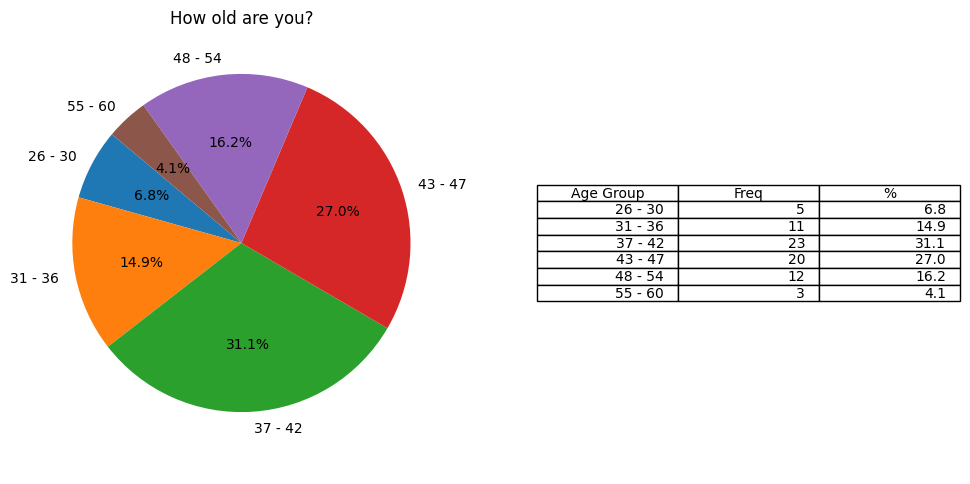

In [11]:
# DataFrame data from idade_sts
labels = idade_sts['FaixaEtaria']
sizes = idade_sts['qtde']

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.set_title('How old are you?')

# Table
table_data = idade_sts[['FaixaEtaria', 'qtde', 'pct']]
table_data.rename(columns={"FaixaEtaria": "Age Group", "qtde": "Freq", "pct": "%"}, inplace=True)
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')

plt.show()

In [12]:
# Creating a LaTeX table using the `tabulate` package
latex_table_q1 = tabulate(idade_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table
print(latex_table_q1)

\begin{tabular}{lrr}
\hline
 26 - 30 &  5 &  6.8 \\
 31 - 36 & 11 & 14.9 \\
 37 - 42 & 23 & 31.1 \\
 43 - 47 & 20 & 27.0 \\
 48 - 54 & 12 & 16.2 \\
 55 - 60 &  3 &  4.1 \\
\hline
\end{tabular}


### Q02 - Which Brazilian state do you live in?
- AC
- AL
- AP
- AM
- BA
- CE
- DF
- ES
- GO
- MA
- MT
- MS
- MG
- PA
- PB
- PR
- PE
- PI
- RJ
- RN
- RS
- RO
- RR
- SC
- SP
- SE
- TO
- None (I live outside Brazil)

In [13]:
#estados_regiao = {
#    "AC": "Norte",
#    "AL": "Nordeste",
#    "AM": "Norte",
#    "AP": "Norte",
#    "BA": "Nordeste",
#    "CE": "Nordeste",
#    "DF": "Centro-Oeste",
#    "ES": "Sudeste",
#    "GO": "Centro-Oeste",
#    "MA": "Nordeste",
#    "MG": "Sudeste",
#    "MS": "Centro-Oeste",
#    "MT": "Centro-Oeste",
#    "PA": "Norte",
#    "PB": "Nordeste",
#    "PE": "Nordeste",
#    "PI": "Nordeste",
#    "PR": "Sul",
#    "RJ": "Sudeste",
#    "RN": "Nordeste",
#    "RS": "Sul",
#    "RO": "Norte",
#    "RR": "Norte",
#    "SC": "Sul",
#    "SE": "Nordeste",
#    "SP": "Sudeste",
#    "TO": "Norte",
#    "Nenhum (moro fora do Brasil)":"Exterior"
#}

#estado_moradia_sts['regiao_brasil'] = estado_moradia_sts['regiao_brasil'].replace(["Centro-Oeste", 
#                                                                         "Exterior",
#                                                                         "Nordeste",
#                                                                         "Norte",
#                                                                         "Sudeste",
#                                                                         "Sul"],
#                                                                         ["Midwest",
#                                                                          "Abroad",
#                                                                          "Northeast",
#                                                                          "North",
#                                                                          "Southeast",
#                                                                          "South"])

In [14]:
# Mapping of Brazilian states to regions
estados_regiao = {
    "AC": "North",
    "AL": "Northeast",
    "AM": "North",
    "AP": "North",
    "BA": "Northeast",
    "CE": "Northeast",
    "DF": "MidWest",
    "ES": "Southeast",
    "GO": "MidWest",
    "MA": "Northeast",
    "MG": "Southeast",
    "MS": "MidWest",
    "MT": "MidWest",
    "PA": "North",
    "PB": "Northeast",
    "PE": "Northeast",
    "PI": "Northeast",
    "PR": "South",
    "RJ": "Southeast",
    "RN": "Northeast",
    "RS": "South",
    "RO": "North",
    "RR": "North",
    "SC": "South",
    "SE": "Northeast",
    "SP": "Southeast",
    "TO": "North",
    "Nenhum (moro fora do Brasil)": "Abroad"
}

In [15]:
# Creating a DataFrame with the column "2. Em qual Estado você mora?"
estado_moradia = df["2. Em qual Estado você mora?"].to_frame()

# Mapping states to regions using the 'estados_regiao' dictionary
estado_moradia["Região"] = estado_moradia['2. Em qual Estado você mora?'].map(estados_regiao)

# Counting the occurrences of each region
estado_moradia_sts = estado_moradia["Região"].value_counts().to_frame()

# Resetting the index to convert the index to a column
estado_moradia_sts = estado_moradia_sts.reset_index(drop=False)
estado_moradia_sts = estado_moradia_sts.rename(columns={'index': 'regiao_brasil','Região':'qtde'})

# Calculating the percentage of each region
estado_moradia_sts['pct'] = ((estado_moradia_sts['qtde']/df.shape[0])*100).round(1)

# Creating a dictionary to map regions to numerical values
mapping_dict = {'North': 1,
                'Northeast': 2,
                'MidWest': 3,
                'Southeast': 4,
                "South": 5,
                "Abroad": 6}

# Creating a new column 'ord_regiao' based on the mapping dictionary for sorting
estado_moradia_sts['ord_regiao'] = estado_moradia_sts['regiao_brasil'].map(mapping_dict)

# Sorting the DataFrame by 'ord_regiao' in ascending order and dropping the column
estado_moradia_sts = estado_moradia_sts.sort_values(by='ord_regiao', ascending=True)
estado_moradia_sts.drop('ord_regiao', axis=1, inplace=True)
estado_moradia_sts = estado_moradia_sts.reset_index(drop=True)

# Returning the DataFrame with state region statistics
# estado_moradia_sts

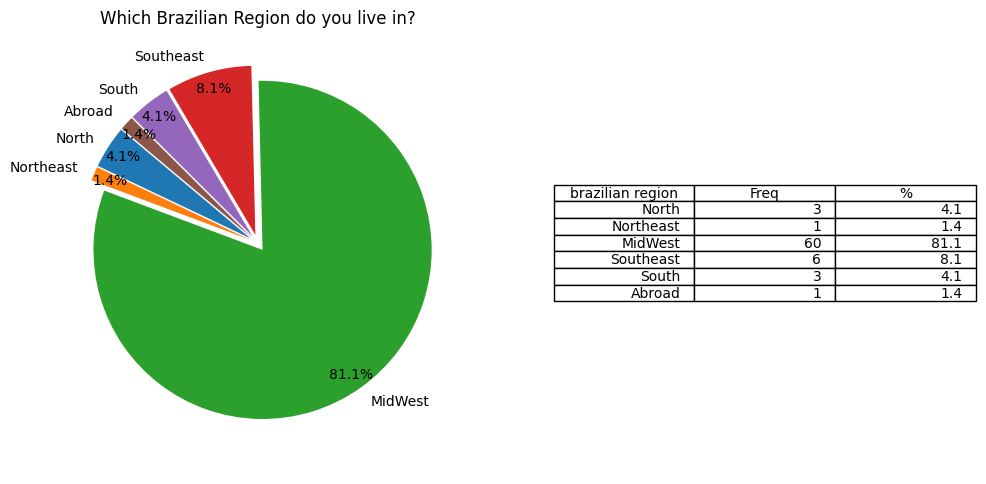

In [16]:
# DataFrame data from idade_sts
labels = estado_moradia_sts['regiao_brasil']
sizes = estado_moradia_sts['qtde']

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,explode = [0.05]*6,pctdistance=0.9)
ax1.set_title('Which Brazilian Region do you live in?')

# Table
table_data = estado_moradia_sts[['regiao_brasil', 'qtde', 'pct']]
table_data.rename(columns={"regiao_brasil": "brazilian region", "qtde": "Freq", "pct": "%"}, inplace=True)
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')

plt.show()

In [17]:
# Creating a LaTeX table using the `tabulate` package
tabela_latex_q2 = tabulate(estado_moradia_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table
print(tabela_latex_q2)

\begin{tabular}{lrr}
\hline
 North     &  3 &  4.1 \\
 Northeast &  1 &  1.4 \\
 MidWest   & 60 & 81.1 \\
 Southeast &  6 &  8.1 \\
 South     &  3 &  4.1 \\
 Abroad    &  1 &  1.4 \\
\hline
\end{tabular}


### Q03 - What is your level of education?
- High school
- Graduate
- Postgraduate degree (Specialization) or MBA
- Master's degree
- Doctorate

In [18]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
nivel_escolaridade_sts = df["3. Qual seu nível de escolaridade?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
nivel_escolaridade_sts = nivel_escolaridade_sts.reset_index(drop=False)
nivel_escolaridade_sts = nivel_escolaridade_sts.rename(columns={'index': 'Escolaridade'})

# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Graduado': 1,
                'Pós-graduação Lato Sensu (Especialização) ou MBA': 2,
                'Mestrado': 3,
                'Doutorado': 4}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
nivel_escolaridade_sts['ord_escolaridade'] = nivel_escolaridade_sts['Escolaridade'].map(mapping_dict)

# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
nivel_escolaridade_sts = nivel_escolaridade_sts.sort_values(by='ord_escolaridade', ascending=True)
nivel_escolaridade_sts.drop('ord_escolaridade', axis=1, inplace=True)
nivel_escolaridade_sts = nivel_escolaridade_sts.reset_index(drop=True)

# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
nivel_escolaridade_sts.rename(columns={'3. Qual seu nível de escolaridade?': 'qtde'}, inplace=True)
nivel_escolaridade_sts['pct'] = ((nivel_escolaridade_sts['qtde']/df.shape[0])*100).round(1)

# Translating the 'Escolaridade' column values to English
nivel_escolaridade_sts['Escolaridade'] = nivel_escolaridade_sts['Escolaridade'].replace(["Graduado", 
                                                                         "Pós-graduação Lato Sensu (Especialização) ou MBA",
                                                                         "Mestrado",
                                                                         "Doutorado"],
                                                                         ["Graduated",
                                                                          "Specialist",
                                                                          "Master",
                                                                          "PhD"])
#nivel_escolaridade_sts

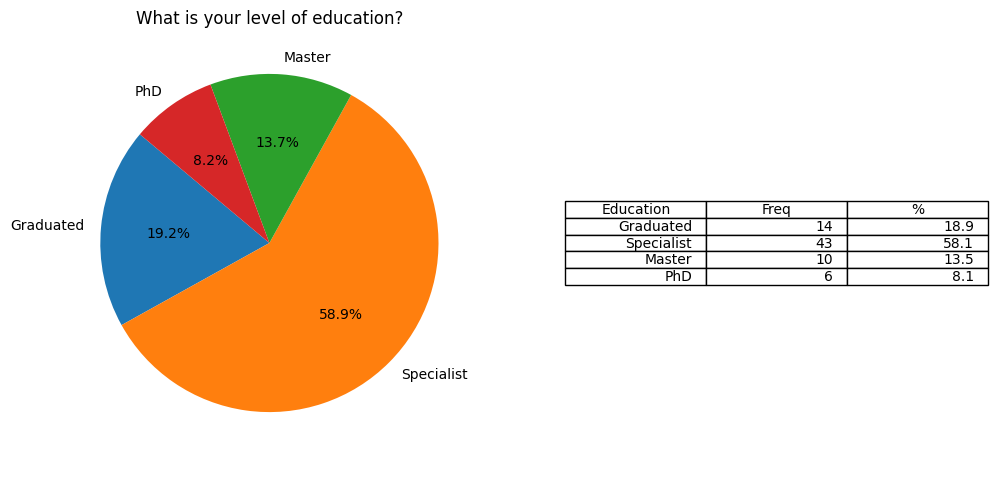

In [19]:
# DataFrame data from idade_sts
labels = nivel_escolaridade_sts['Escolaridade']
sizes = nivel_escolaridade_sts['qtde']

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.set_title('What is your level of education?')

# Table
table_data = nivel_escolaridade_sts[['Escolaridade', 'qtde', 'pct']]
table_data.rename(columns={"Escolaridade": "Education", "qtde": "Freq", "pct": "%"}, inplace=True)
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')

plt.show()

In [20]:
# Creating the LaTeX table using the `tabulate` package
tabela_latex_q3 = tabulate(nivel_escolaridade_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table
print(tabela_latex_q3)

\begin{tabular}{lrr}
\hline
 Graduated  & 14 & 18.9 \\
 Specialist & 43 & 58.1 \\
 Master     & 10 & 13.5 \\
 PhD        &  6 &  8.1 \\
\hline
\end{tabular}


### Q04 - What is your main role currently in the software development area?
- Product Owner
- Project Manager
- Scrum Master
- Technical and/or Team Leader
- Business Analyst
- Software Requirements Analyst
- Software Architect
- Programmer and/or Developer
- Quality Analyst and/or Tester
- Designer and/or UI/UX Specialist
- Engineer and/or Data Analyst
- DevOps Engineer
- Other:

In [21]:
perfil = df["4. Qual é a sua principal função atualmente na área de desenvolvimento de software?"].str.strip()

perfil = perfil.replace(["Teste","AppSec","Administrador de Banco de Dados"],
                        ["Analista de qualidade e/ou testador","Analista de Segurança de TI","Administrador de Dados"])
perfil_sts = perfil.value_counts().to_frame()


# Resetting the index to convert the index to a column
perfil_sts = perfil_sts.reset_index(drop=False)
perfil_sts = perfil_sts.rename(columns={'index': 'perfil'})
perfil_sts.rename(columns={'4. Qual é a sua principal função atualmente na área de desenvolvimento de software?': 'qtde'}, inplace=True)

perfil_sts

# Calculating the percentage of each 'perfil' category
perfil_sts['pct'] = ((perfil_sts['qtde'] / df.shape[0]) * 100).round(1)

#perfil_sts['perfil'] = perfil_sts['perfil'].str.strip()

# Replacing Portuguese names with English equivalents for 'perfil'
perfil_sts['perfil'] = perfil_sts['perfil'].replace([
    "Administrador de Dados",
    "Analista de Segurança de TI",
    "Analista de qualidade e/ou testador",
    "Analista de requisitos",
    "Arquiteto de Software",
    "Dono do Produto (Product Owner)",
    "Engenheiro DevOps",
    "Engenheiro e/ou analista de dados",
    "Gerente de projeto",
    "Líder técnico e/ou de equipe",
    "Programador e/ou desenvolvedor"],
    [
    "Data Administrator",
    "IT Security Analyst",
    "Quality Analyst and/or Tester",
    "Software Requirements Analyst",
    "Software Architect",
    "Product Owner",
    "DevOps Engineer",
    "Data Engineer and/or Analyst",
    "Project Manager",
    "Technical and/or Team Leader",
    "Programmer and/or Developer"])

# Sorting the DataFrame by 'perfil' in ascending order and resetting the index
perfil_sts = perfil_sts.sort_values(by='perfil', ascending=True)
perfil_sts = perfil_sts.reset_index(drop=True)

# Returning the processed DataFrame
#perfil_sts

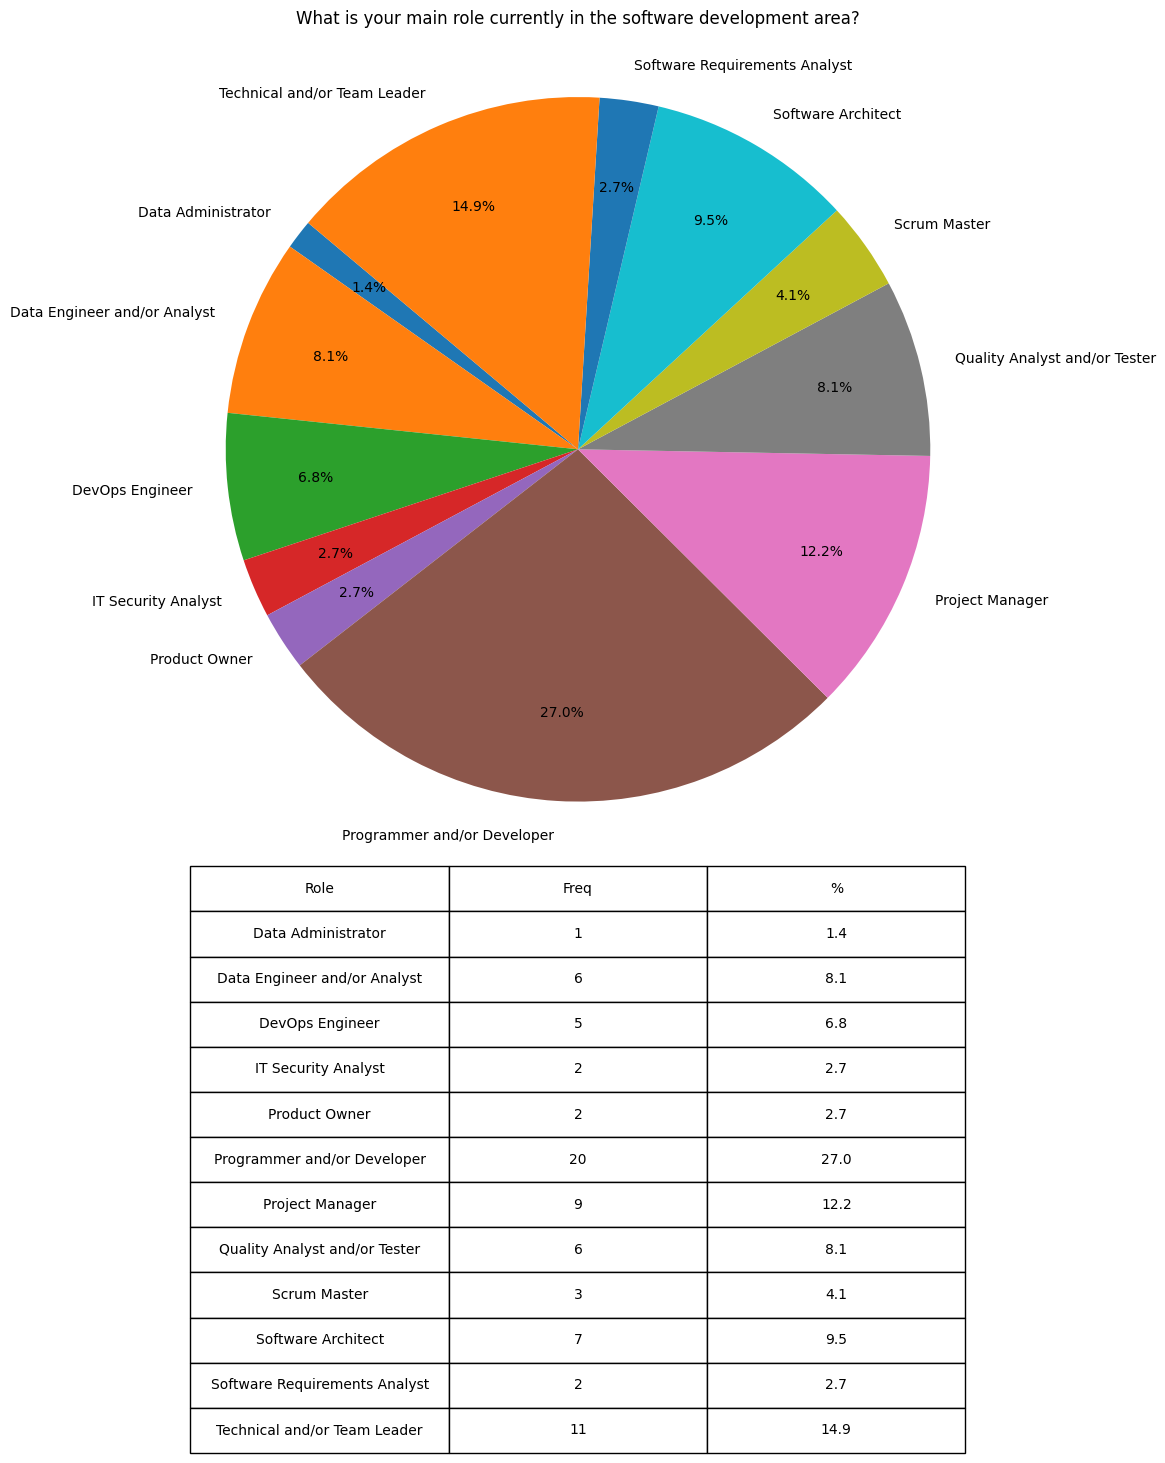

In [22]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = perfil_sts['qtde']
labels = perfil_sts['perfil']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your main role currently in the software development area?')

# Adjusting the position and size of the table
table_data = perfil_sts[['perfil', 'qtde', 'pct']]
table_data.rename(columns={"perfil": "Role", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

In [23]:
# Creating the LaTeX table using the `tabulate` package
latex_table_q4 = tabulate(perfil_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table
print(latex_table_q4)

\begin{tabular}{lrr}
\hline
 Data Administrator            &  1 &  1.4 \\
 Data Engineer and/or Analyst  &  6 &  8.1 \\
 DevOps Engineer               &  5 &  6.8 \\
 IT Security Analyst           &  2 &  2.7 \\
 Product Owner                 &  2 &  2.7 \\
 Programmer and/or Developer   & 20 & 27.0 \\
 Project Manager               &  9 & 12.2 \\
 Quality Analyst and/or Tester &  6 &  8.1 \\
 Scrum Master                  &  3 &  4.1 \\
 Software Architect            &  7 &  9.5 \\
 Software Requirements Analyst &  2 &  2.7 \\
 Technical and/or Team Leader  & 11 & 14.9 \\
\hline
\end{tabular}


### Q5 - How many years of experience do you have working in software development?
- Less than 1 year
- Between 1 and 3 years
- Between 4 and 6 years
- Between 7 and 9 years
- Between 10 and 12 years
- Between 13 and 15 years
- Over 15 years

In [24]:
experiencia_sts = df["5. Quantos anos de experiência você tem trabalhando em desenvolvimento de software?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
experiencia_sts = experiencia_sts.reset_index(drop=False)
experiencia_sts = experiencia_sts.rename(columns={'index': 'experiencia'})
experiencia_sts.rename(columns={'5. Quantos anos de experiência você tem trabalhando em desenvolvimento de software?': 'qtde'}, inplace=True)

# Creating a dictionary to map experience levels to numerical values
mapping_dict = {'Menos de 1 ano': 1,
                'Entre 1 e 3 anos': 2,
                'Entre 4 e 6 anos': 3,
                'Entre 7 e 9 anos': 4,
                'Entre 10 e 12 anos': 5,
                'Entre 13 e 15 anos': 6,
                'Mais de 15 anos': 7}

# Creating a new column 'ord_experiencia' based on the mapping dictionary for sorting
experiencia_sts['ord_experiencia'] = experiencia_sts['experiencia'].map(mapping_dict)

# Sorting the DataFrame by 'ord_experiencia' in ascending order and dropping the column
experiencia_sts = experiencia_sts.sort_values(by='ord_experiencia', ascending=True)
experiencia_sts.drop('ord_experiencia', axis=1, inplace=True)
experiencia_sts = experiencia_sts.reset_index(drop=True)

# Calculating the percentage of each experience level
experiencia_sts['pct'] = ((experiencia_sts['qtde'] / df.shape[0]) * 100).round(1)

# Replacing long experience level descriptions with shorter ones for clarity
experiencia_sts['experiencia'] = experiencia_sts['experiencia'].replace(["Menos de 1 ano",
                                                                         "Entre 1 e 3 anos",
                                                                         "Entre 4 e 6 anos",
                                                                         "Entre 7 e 9 anos",
                                                                         "Entre 10 e 12 anos",
                                                                         "Entre 13 e 15 anos",
                                                                         "Mais de 15 anos"],
                                                                        ["< 1",
                                                                         "1 - 3",
                                                                         "4 - 6",
                                                                         "7 - 9",
                                                                         "10 - 12",
                                                                         "13 - 15",
                                                                         "> 15"])

#experiencia_sts

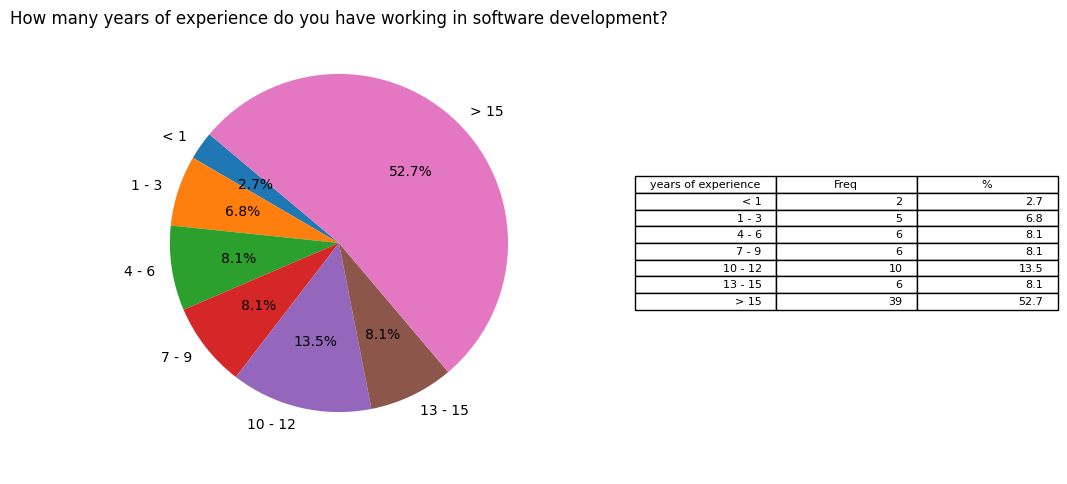

In [25]:
# DataFrame data from idade_sts
labels = experiencia_sts['experiencia']
sizes = experiencia_sts['qtde']

# Creating the pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.set_title('How many years of experience do you have working in software development?')

# Table
table_data = experiencia_sts[['experiencia', 'qtde', 'pct']]
table_data.rename(columns={"experiencia": "years of experience", "qtde": "Freq", "pct": "%"}, inplace=True)
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')

plt.show()

In [26]:
# Creating the LaTeX table using the `tabulate` package
tabela_latex_q5 = tabulate(experiencia_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table
print(tabela_latex_q5)

\begin{tabular}{lrr}
\hline
 \ensuremath{<} 1     &  2 &  2.7 \\
 1 - 3   &  5 &  6.8 \\
 4 - 6   &  6 &  8.1 \\
 7 - 9   &  6 &  8.1 \\
 10 - 12 & 10 & 13.5 \\
 13 - 15 &  6 &  8.1 \\
 \ensuremath{>} 15    & 39 & 52.7 \\
\hline
\end{tabular}


## RQ1 - What is the level of knowledge of Brazilian software developers about basic data privacy concepts?

### Q6 - What is your level of knowledge about data privacy?
- No Knowledge
- Basic Awareness (I have a general idea of what data privacy is)
- Basic Knowledge (I understand the basic principles and rights of data subjects)
- Intermediate Knowledge (I can explain the main concepts and how to apply them in common situations)
- Comprehensive Knowledge (I have a good understanding of the topic, including data privacy laws and regulations)

In [27]:
# Calling the function to process the column '6. Qual seu nível de conhecimento sobre privacidade de dados?'
result_q06 = process_level_knowledge_column(df, "6. Qual seu nível de conhecimento sobre privacidade de dados?")

# Displaying the result
#result_q06

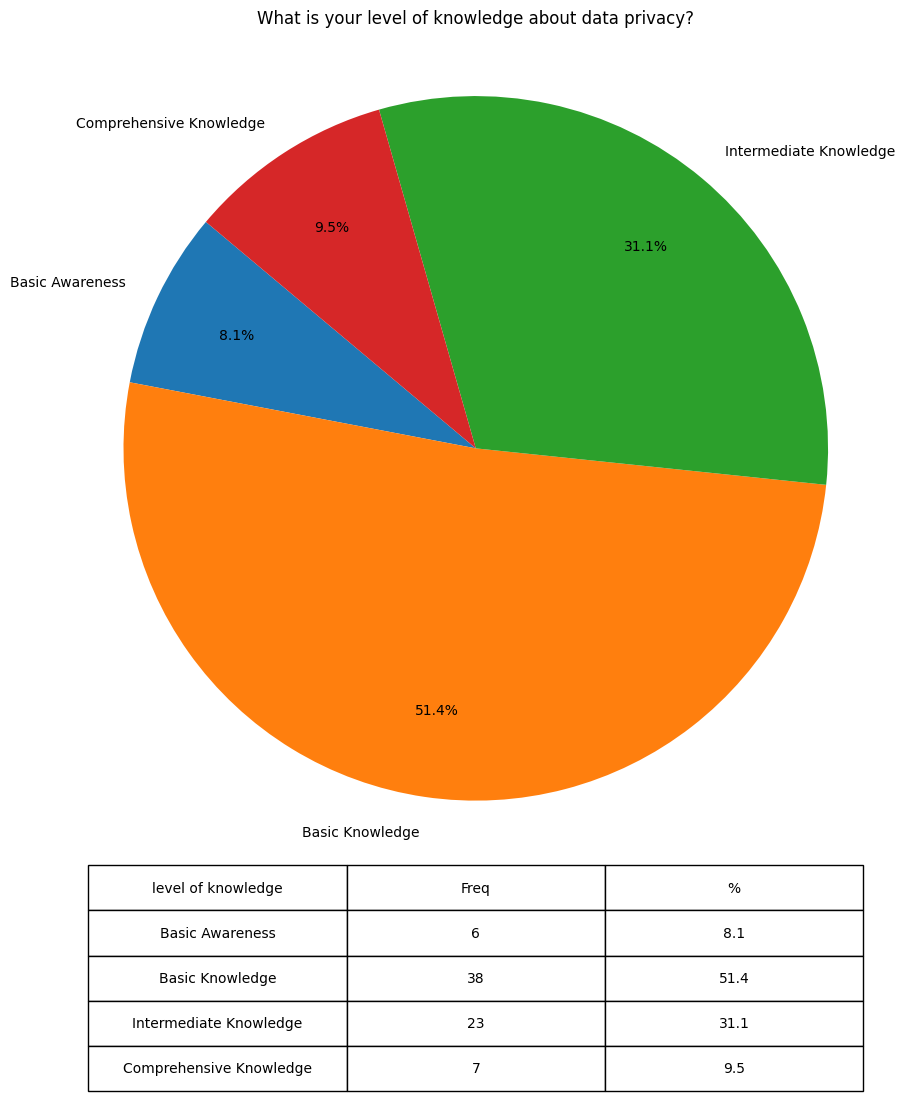

In [28]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q06['qtde']
labels = result_q06['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your level of knowledge about data privacy?')

# Adjusting the position and size of the table
table_data = result_q06[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q7  - Have you ever attended training or courses on data privacy?
- I have never participated
- I have participated in an introductory training
- I have participated in a basic course
- I have participated in an intermediate course
- I have participated in an advanced or specialization training

In [29]:
capacitacao_sts = df["7. Você já participou de treinamentos ou cursos sobre privacidade de dados? "].value_counts().to_frame()
capacitacao_sts = capacitacao_sts.reset_index(drop=False)
capacitacao_sts = capacitacao_sts.rename(columns={'index': 'capacitacao_privacidade'})
capacitacao_sts.rename(columns={'7. Você já participou de treinamentos ou cursos sobre privacidade de dados? ': 'qtde'}, inplace=True)

# Dicionário de tradução
translation_dict = {
    'Nunca participei': 'Never',
    'Participei de um treinamento introdutório': 'Introductory training',
    'Participei de um curso básico': 'Basic course',
    'Participei de um curso intermediário': 'Intermediate course',
    'Participei de um treinamento avançado ou especialização': 'Advanced training or specialization'
}

# Atualizando a coluna com os valores traduzidos
capacitacao_sts['capacitacao_privacidade'] = capacitacao_sts['capacitacao_privacidade'].map(translation_dict)



# Criando um dicionário para mapear os níveis de conhecimento para valores numéricos
dicionario_mapeamento = {'Never': 1,
                         'Introductory training': 2,
                         'Basic course': 3,
                         'Intermediate course': 4,
                         'Advanced training or specialization':5}

# Criando a nova coluna 'ord_conhecimento'
capacitacao_sts['ord_capacitacao'] = capacitacao_sts['capacitacao_privacidade'].map(dicionario_mapeamento)

capacitacao_sts = capacitacao_sts.sort_values(by='ord_capacitacao', ascending=True)
capacitacao_sts.drop('ord_capacitacao', axis=1, inplace=True)
capacitacao_sts = capacitacao_sts.reset_index(drop=True)

capacitacao_sts['pct'] = ((capacitacao_sts['qtde']/df.shape[0])*100).round(1)

#capacitacao_sts

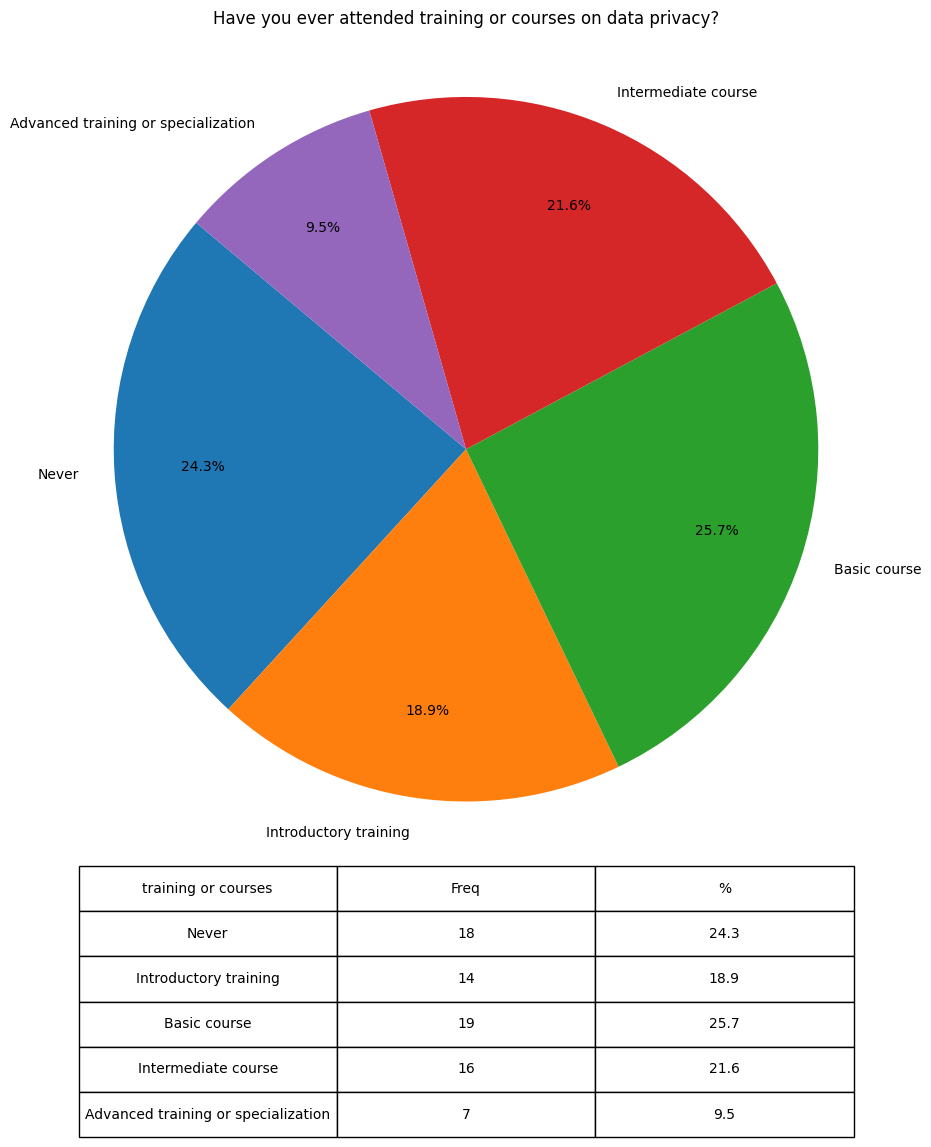

In [30]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = capacitacao_sts['qtde']
labels = capacitacao_sts['capacitacao_privacidade']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Have you ever attended training or courses on data privacy?')

# Adjusting the position and size of the table
table_data = capacitacao_sts[['capacitacao_privacidade', 'qtde', 'pct']]
table_data.rename(columns={"capacitacao_privacidade": "training or courses", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q8 - What is your main source of information about data privacy?
- Courses
- Internet
- Books
- Magazines and articles
- Events and workshops
- Organizations and associations
- Specialized consultancies
- Contact with experts
- Legislative updates
- Other

In [31]:
fonteinformacao_sts = df["8. Qual sua principal fonte de informação sobre privacidade de dados? "].value_counts().to_frame()
fonteinformacao_sts = fonteinformacao_sts.reset_index(drop=False)
fonteinformacao_sts = fonteinformacao_sts.rename(columns={'index': 'fonte_informacao'})
fonteinformacao_sts.rename(columns={'8. Qual sua principal fonte de informação sobre privacidade de dados? ': 'qtde'}, inplace=True)

# Dicionário de tradução
translation_dict = {
    'Internet':'Internet',
    'Cursos': 'Courses',
    'Contato com especialistas': 'Contact with experts',
    'Revistas e artigos': 'Magazines and articles',
    'Organizações e associações': 'Organizations and associations',
    'Eventos e workshops': 'Advanced training or specialization',
    'Atualizações legislativas':'Events and workshops',
    'Várias fontes: portal da ANPD, autoridades de outros países, leis, livros e eventos.':'Multiple sources',
    'Livros':'Books'
}
# Atualizando a coluna com os valores traduzidos
fonteinformacao_sts['fonte_informacao'] = fonteinformacao_sts['fonte_informacao'].map(translation_dict)

fonteinformacao_sts = fonteinformacao_sts.sort_values(by='fonte_informacao', ascending=True)
fonteinformacao_sts = fonteinformacao_sts.reset_index(drop=True)
fonteinformacao_sts['pct'] = ((fonteinformacao_sts['qtde']/df.shape[0])*100).round(1)

#fonteinformacao_sts

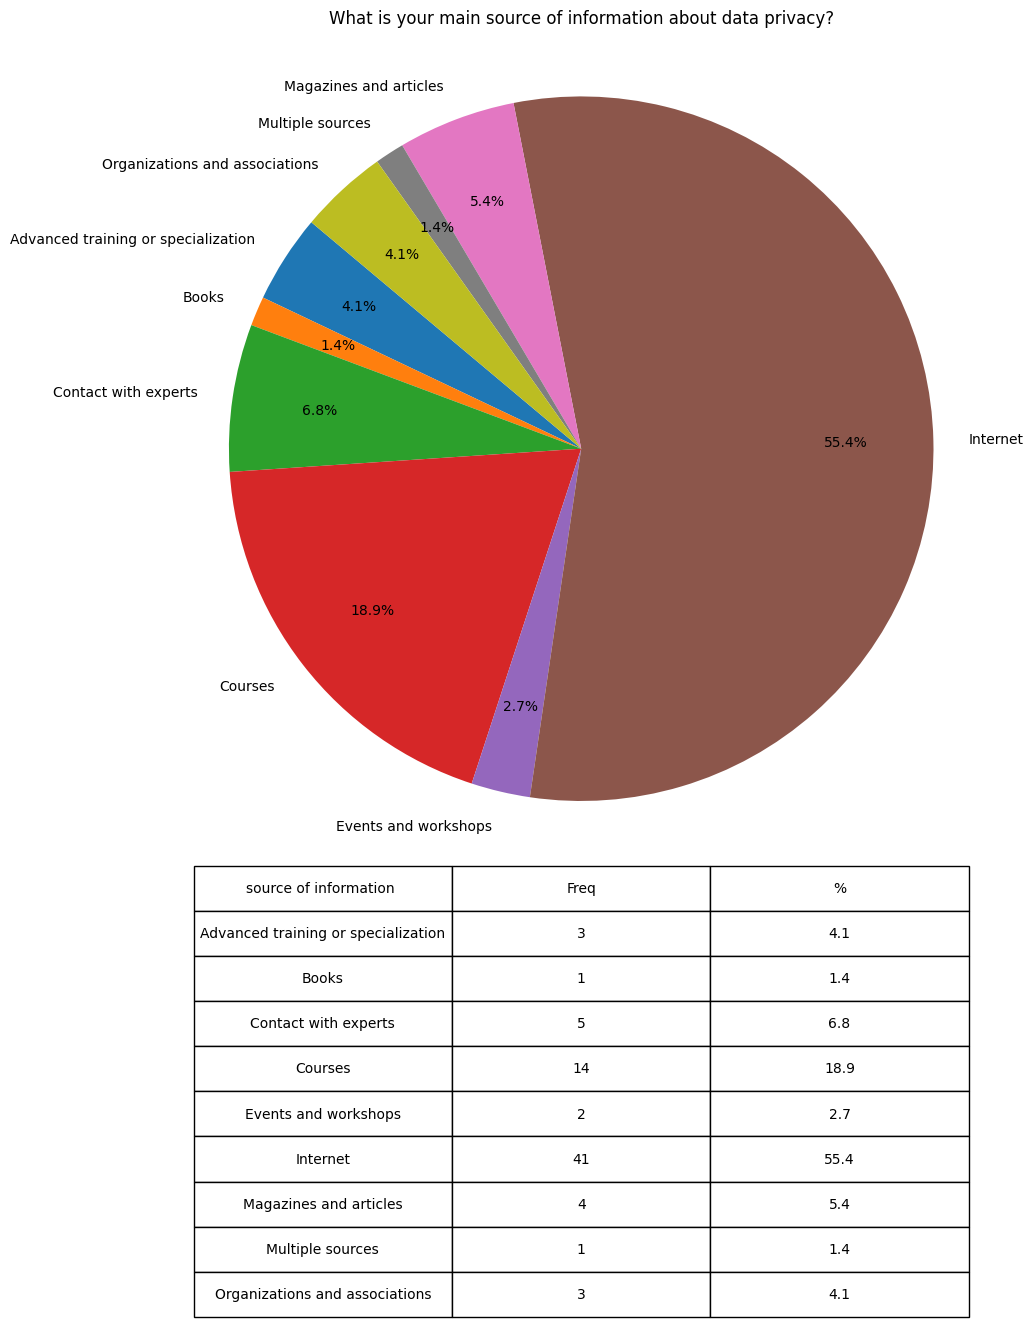

In [32]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = fonteinformacao_sts['qtde']
labels = fonteinformacao_sts['fonte_informacao']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your main source of information about data privacy?')

# Adjusting the position and size of the table
table_data = fonteinformacao_sts[['fonte_informacao', 'qtde', 'pct']]
table_data.rename(columns={"fonte_informacao": "source of information ", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q9 - What is your level of knowledge about the Brazilian General Data Protection Law (LGPD)?
- No knowledge
- Basic Awareness	 (I have a general idea of the principles and rights)
- Basic knowledge (I understand the main points of the law and how to apply them in simple situations)
- Intermediate Knowledge (I can explain the details of the law, including business obligations and data subject rights)
- Comprehensive Knowledge (I have a command of the subject and in-depth knowledge of the legal implications of the LGPD)

In [33]:
result_q09 = process_level_knowledge_column(df, "9.  Qual seu nível de conhecimento sobre a Lei Geral de Proteção de Dados (LGPD)? ")
#result_q09

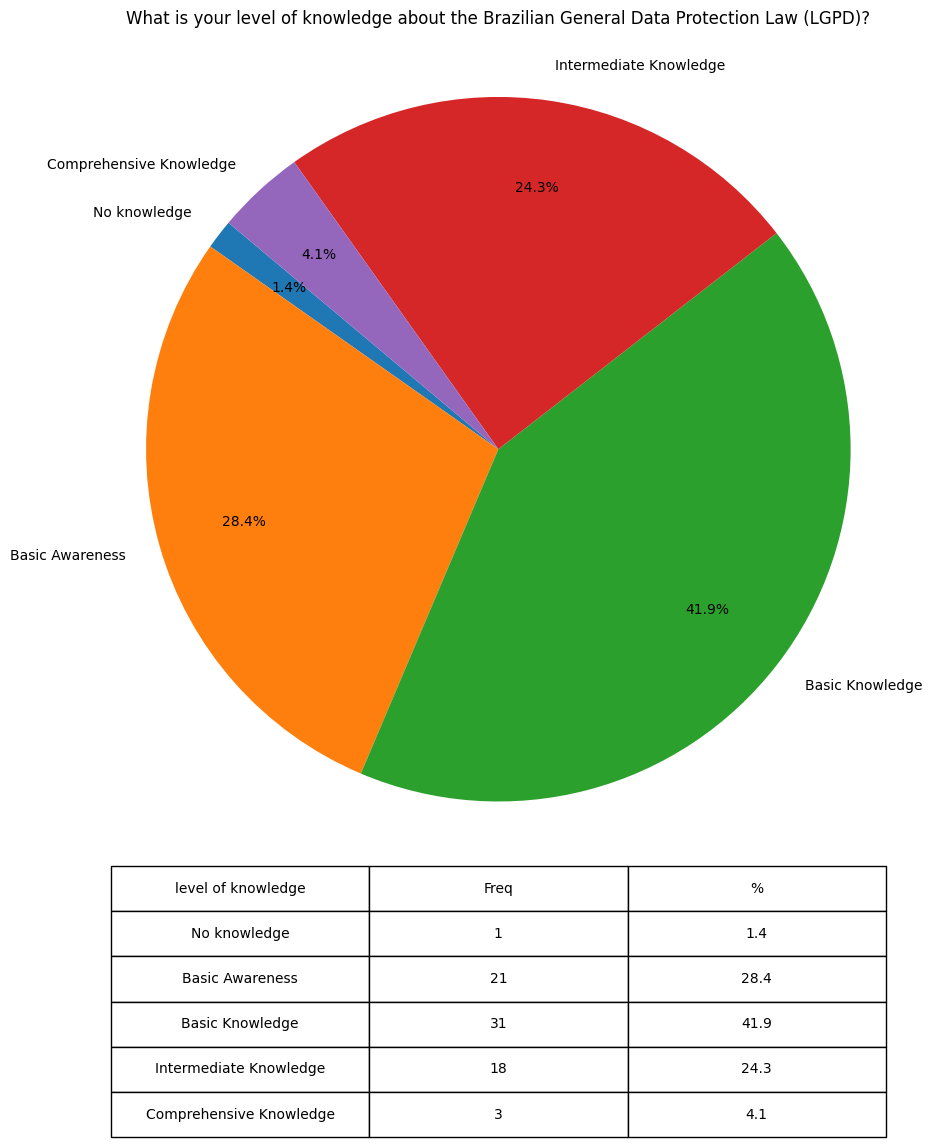

In [34]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q09['qtde']
labels = result_q09['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your level of knowledge about the Brazilian General Data Protection Law (LGPD)?')

# Adjusting the position and size of the table
table_data = result_q09[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q10 - What is your level of knowledge about the principles of the Brazilian General Data Protection Law (LGPD)?
- No knowledge
- Basic Awareness (I have a general idea of ​​the principles, but need more information)
- Basic knowledge (I understand the main principles and how they apply in simple situations)
- Intermediate Knowledge (I can explain the principles in detail and with examples, including how to identify violations of the LGPD)
- Comprehensive Knowledge (I have mastery of the subject and can explain all the principles of the LGPD in depth, including their legal implications)

In [35]:
result_q10 = process_level_knowledge_column(df, "10. Qual seu nível de conhecimento sobre os princípios da Lei Geral de Proteção de Dados (LGPD)? ")
#result_q10

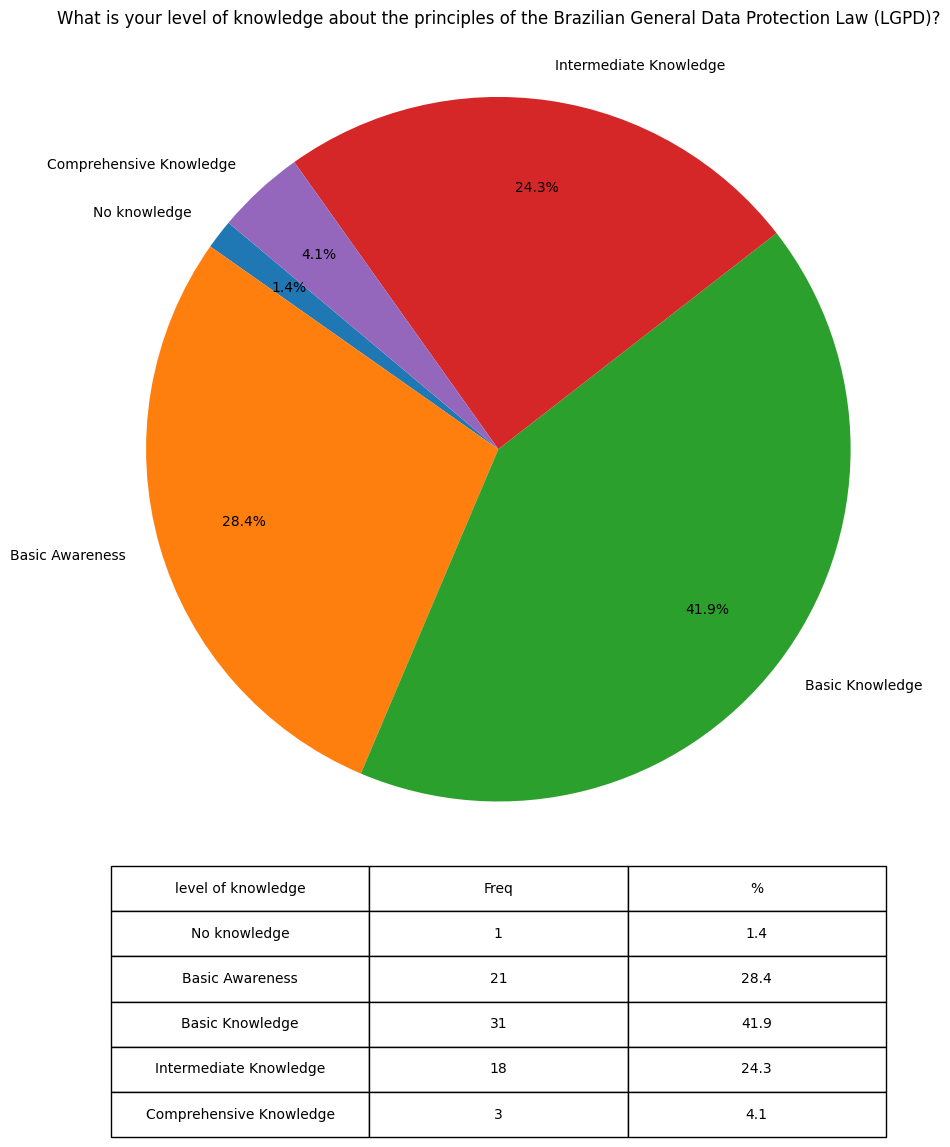

In [36]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q09['qtde']
labels = result_q09['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your level of knowledge about the principles of the Brazilian General Data Protection Law (LGPD)?')

# Adjusting the position and size of the table
table_data = result_q09[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q11 - What are the main principles of the LGPD that you know?
- None
- Purpose
- Adequacy
- Need
- Open Access
- Data Quality
- Transparency
- Security
- Prevention
- Non-Discrimination
- Accountability

In [37]:
column_name = "11. Quais são os principais princípios da LGPD que você conhece? (Marque todas as opções que se aplicam)"
result_q11 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Finalidade':'Purpose',
    'Adequação': 'Adequacy',
    'Necessidade': 'Need',
    'Livre Acesso': 'Open Access',
    'Qualidade dos Dados': 'Data Quality',
    'Transparência': 'Transparency',
    'Segurança': 'Security',
    'Prevenção': 'Prevention',
    'Não Descriminação': 'Non-Discrimination',
    'Responsabilização e prestação de contas': 'Accountability',
    'Nenhum': 'None'
}
# Atualizando a coluna com os valores traduzidos
result_q11['answer'] = result_q11['answer'].map(translation_dict)

result_q11 = result_q11.sort_values(by='answer', ascending=True)
result_q11 = result_q11.reset_index(drop=True)

#result_q11

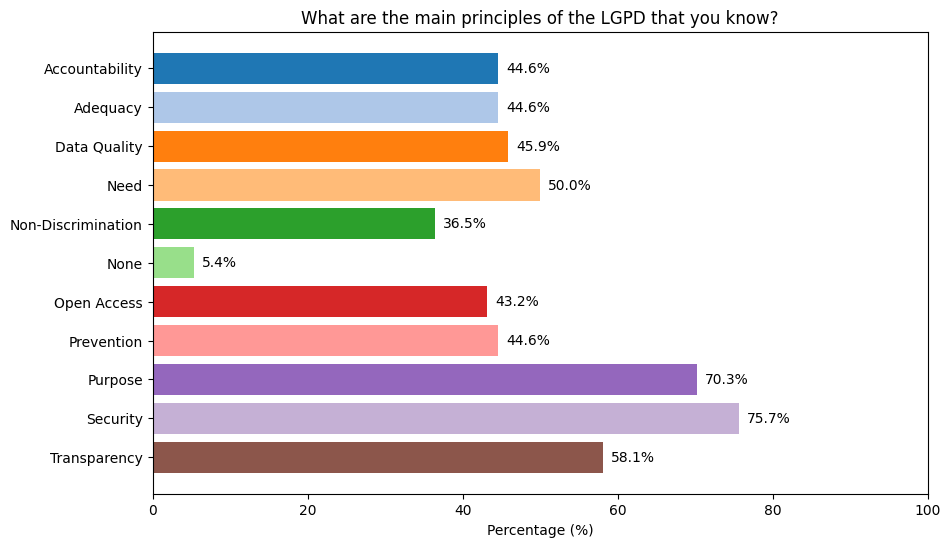

,LGPD principles,Freq,%
0,Accountability,33,44.6
1,Adequacy,33,44.6
2,Data Quality,34,45.9
3,Need,37,50.0
4,Non-Discrimination,27,36.5
5,None,4,5.4
6,Open Access,32,43.2
7,Prevention,33,44.6
8,Purpose,52,70.3
9,Security,56,75.7


In [38]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q11)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q11['answer'], result_q11['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q11['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('What are the main principles of the LGPD that you know?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q11[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LGPD principles", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q12 - Which of the following LGPD data protection concepts are you familiar with?
- Personal data
- Sensitive personal data
- Processing of personal data
- Processing of sensitive personal data
- Anonymization and/or pseudonymization of personal data
- Agents processing personal data
- Consent of the data subject
- Rights of the data subject (e.g. access, correction, deletion)
- Accountability and compensation for damages
- Penalties for non-compliance with the LGPD
- Other

In [39]:
column_name = "12. Quais dos seguintes conceitos de proteção de dados da LGPD você está familiarizado? (Marque todas as opções que se aplicam)"
result_q12 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Dados pessoais':'Personal data',
    'Dados pessoais sensíveis':'Sensitive personal data',
    'Tratamento de dados pessoais':'Processing of personal data',
    'Tratamento de dados pessoais sensíveis':'Processing of sensitive personal data',
    'Anonimização e/ou pseudonimização de dados pessoais':'Anonymization and/or pseudonymization of personal data',
    'Agentes de tratamento de dados pessoais':'Agents processing personal data',
    'Consentimento do titular dos dados':'Consent of the data subject',
    'Direitos do titular dos dados (ex: acesso, correção, exclusão)':'Rights of the data subject (e.g. access, correction, deletion)',
    'Responsabilização e ressarcimento de danos':'Accountability and compensation for damages',
    'Sanções por descumprimento da LGPD':'Penalties for non-compliance with the LGPD',
    'Controles de proteção, riscos, transparência, cláusulas contratuais, transferência internacional e privacy enhance technology':'Other'
}
# Atualizando a coluna com os valores traduzidos
result_q12['answer'] = result_q12['answer'].map(translation_dict)

result_q12 = result_q12.sort_values(by='answer', ascending=True)
result_q12 = result_q12.reset_index(drop=True)


#result_q12

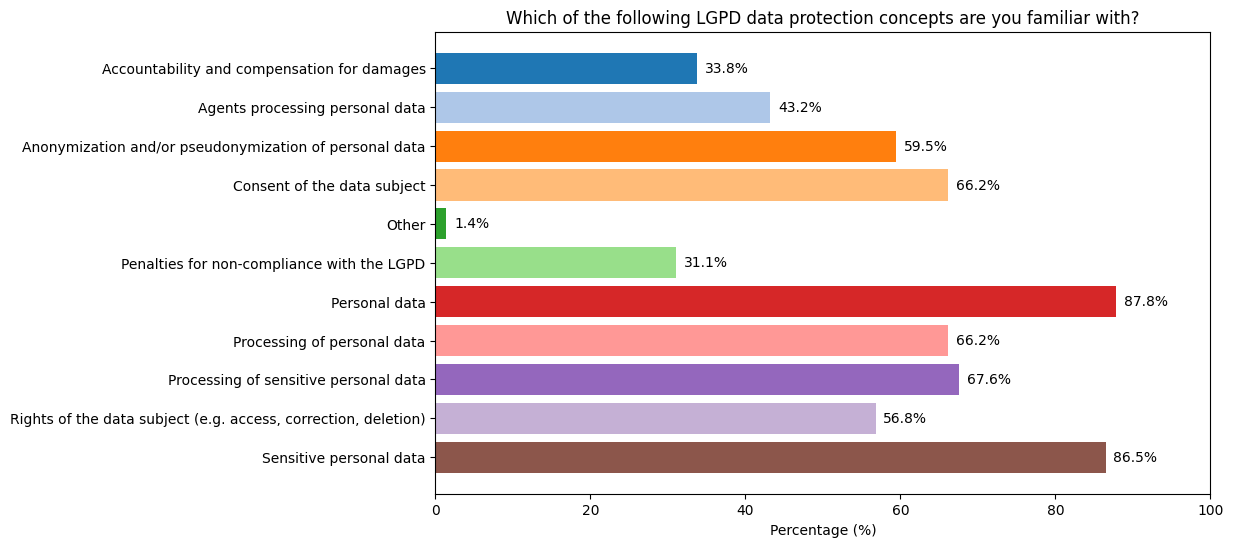

,LGPD data protection concepts,Freq,%
0,Accountability and compensation for damages,25,33.8
1,Agents processing personal data,32,43.2
2,Anonymization and/or pseudonymization of personal data,44,59.5
3,Consent of the data subject,49,66.2
4,Other,1,1.4
5,Penalties for non-compliance with the LGPD,23,31.1
6,Personal data,65,87.8
7,Processing of personal data,49,66.2
8,Processing of sensitive personal data,50,67.6
9,"Rights of the data subject (e.g. access, correction, deletion)",42,56.8


In [40]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q12['answer'], result_q12['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q12['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Which of the following LGPD data protection concepts are you familiar with?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q12[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LGPD data protection concepts", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q13 - What is your level of knowledge about the differences between personal data and sensitive data?
- No knowledge
- Basic Awareness (I have a general idea, but need more information)
- Basic knowledge (I understand the main concepts and some differences)
- Intermediate Knowledge	 (I can explain the differences with examples and apply the knowledge in simple situations)
- Comprehensive Knowledge (I have mastered the topic and can explain the differences in detail, including legal implications)

In [41]:
result_q13 = process_level_knowledge_column(df, "13. Qual o seu nível de conhecimento sobre as diferenças entre dados pessoais e dados sensíveis? ")
#result_q13

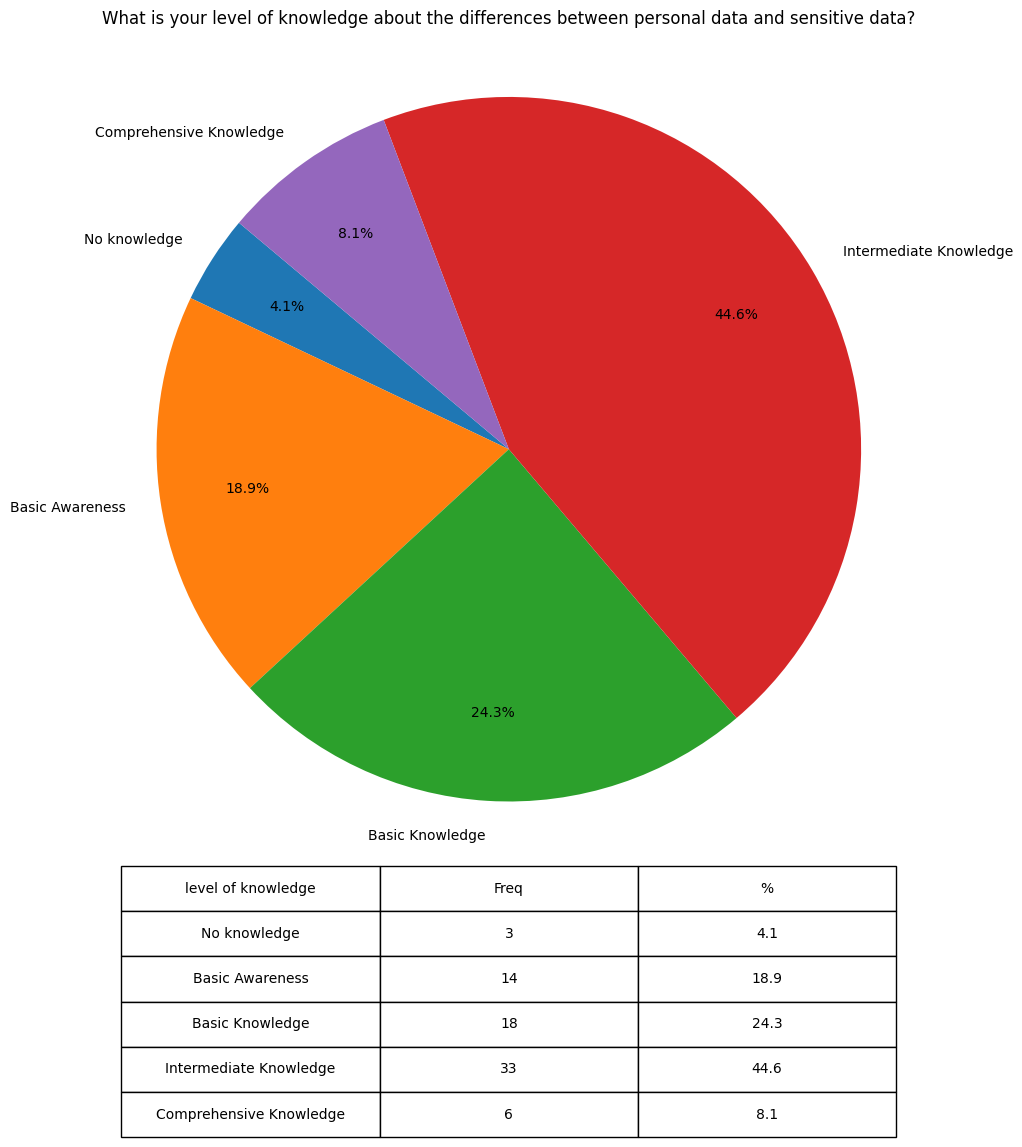

In [42]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q13['qtde']
labels = result_q13['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your level of knowledge about the differences between personal data and sensitive data?')

# Adjusting the position and size of the table
table_data = result_q13[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q14 - What is your level of knowledge about data subject rights under the LGPD?
- No knowledge
- Basic Awareness (I have a general idea of ​​the rights, but need more information)
- Basic knowledge (I understand the main rights and how to exercise them in simple situations)
- Intermediate Knowledge (I can explain the rights in detail and with examples, including how to request access to my data)
- Comprehensive Knowledge (I have mastered the subject and can explain all the rights of data subjects, including how to appeal in case of violations)

In [43]:
result_q14 = process_level_knowledge_column(df, "14. Qual o seu nível de conhecimento sobre os direitos dos titulares de dados sob a LGPD?")
#result_q14

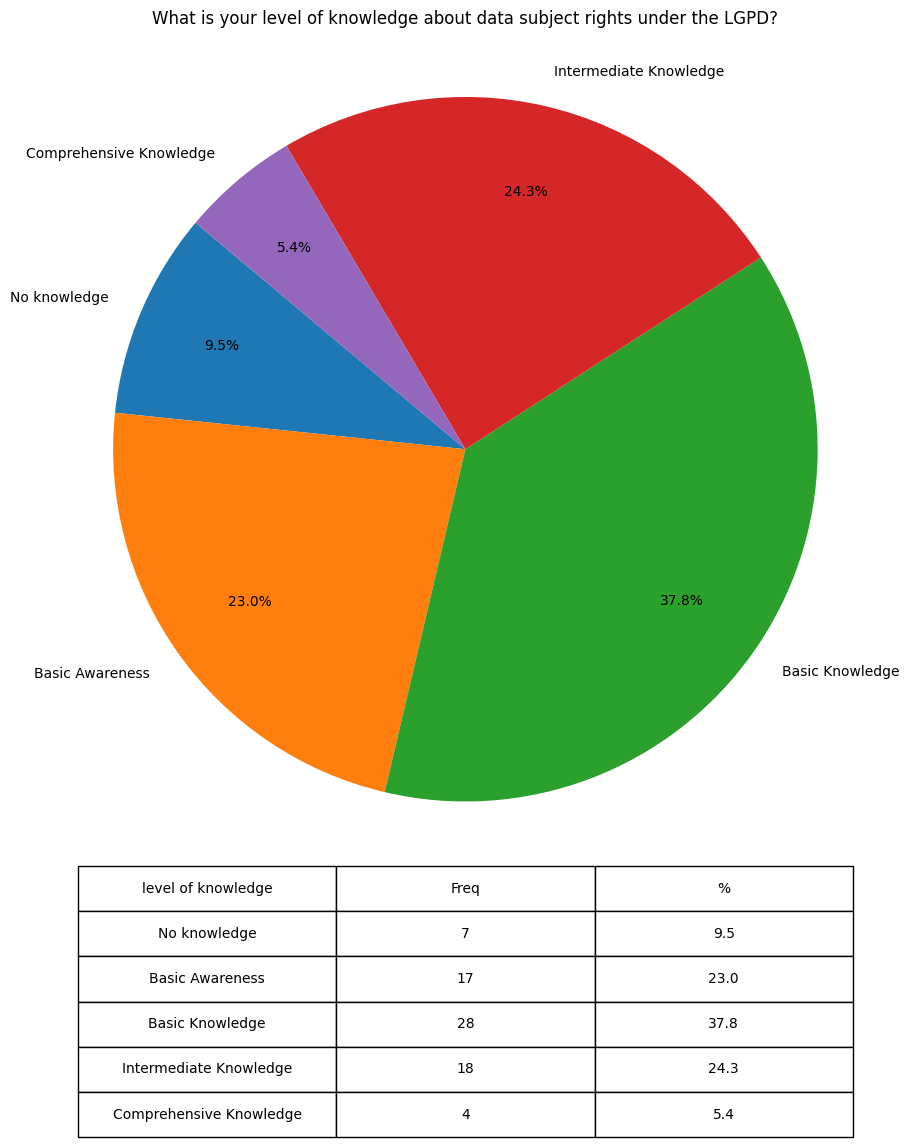

In [44]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q14['qtde']
labels = result_q14['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your level of knowledge about data subject rights under the LGPD?')

# Adjusting the position and size of the table
table_data = result_q14[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q15 - How would you ensure data privacy in a software system?
Open question

In [45]:
# Creating a DataFrame with a specific column related to data privacy
df_filtered = df['15. Como você garantiria a privacidade de dados em um sistema de software?'].to_frame()

# Dropping rows with missing values in the specified column
df_filtered = df_filtered.dropna(subset=['15. Como você garantiria a privacidade de dados em um sistema de software?'])

# Resetting the index of the DataFrame after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent
df_filtered = df_filtered.rename(columns={'15. Como você garantiria a privacidade de dados em um sistema de software?': 
                        '15. How would you ensure data privacy in a software system?'})

df_filtered

,15. How would you ensure data privacy in a software system?
0,"Aplicação do privacy by design com implementação dos controles necessários, relatório de impacto à proteção de dados no início do projeto, transparência e uso de PETs (privacy enhance technologies)."
1,"Uso de provedor seguro, criptografia de dados em trânsito e armazenados e atualizações de infraestrutura e softwares."
2,criptografia assimétrica
3,Com criptografia
4,Realizando o controle em conformidade com o consentimento do proprietário dos dados pessoais.
5,"Identificação e categorização dos dados, sistemas de controle de acesso com diferentes níveis de hierarquia , sistemas de proteção e prevenção a invasão, não manter dados desnecessários para o negocio, Anonimização de dados quando possível, termo de utilização e responsabilização para os usuários."
6,Segurança reforçada nos dados armazenados.
7,-
8,Não compartilhando ou deixando visível informações pessoais sem o consentimento do dono.
9,"Existem várias formas com usos de rede interna, criptografias de ponta a ponta, educando os times sobre a importância da privacidade dos dados, nunca logar dados sensíveis nas aplicações e etc..."


## RQ2 - What is the level of knowledge of Brazilian software developers about LLMs?


### Q16 - How would you rate your knowledge of LLMs?
- No knowledge
- Basic (I have a general idea)
- Intermediate (I understand the basic operation)
- Advanced (I have knowledge of applications and implications)
- Expert (I have mastery of the subject and in-depth technical knowledge)

In [46]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
question_sts = df["16. Como você classificaria seu conhecimento sobre LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
question_sts = question_sts.reset_index(drop=False)
question_sts = question_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
question_sts["question_anwser"] = question_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Sem conhecimento': 1,
                'Básico': 2,
                'Intermediário': 3,
                'Avançado': 4,
                'Especialista': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
question_sts['ord_question_anwser'] = question_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
question_sts = question_sts.sort_values(by='ord_question_anwser', ascending=True)
question_sts.drop('ord_question_anwser', axis=1, inplace=True)
question_sts = question_sts.reset_index(drop=True)

# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
question_sts.rename(columns={'16. Como você classificaria seu conhecimento sobre LLMs? ': 'qtde'}, inplace=True)
question_sts['pct'] = ((question_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {
    'Sem conhecimento':'No knowledge',
    'Básico':'Basic',
    'Intermediário':'Intermediate',
    'Avançado':'Advanced',
    'Especialista':'Expert'
    }
# Atualizando a coluna com os valores traduzidos
question_sts['question_anwser'] = question_sts['question_anwser'].map(translation_dict)


#question_sts

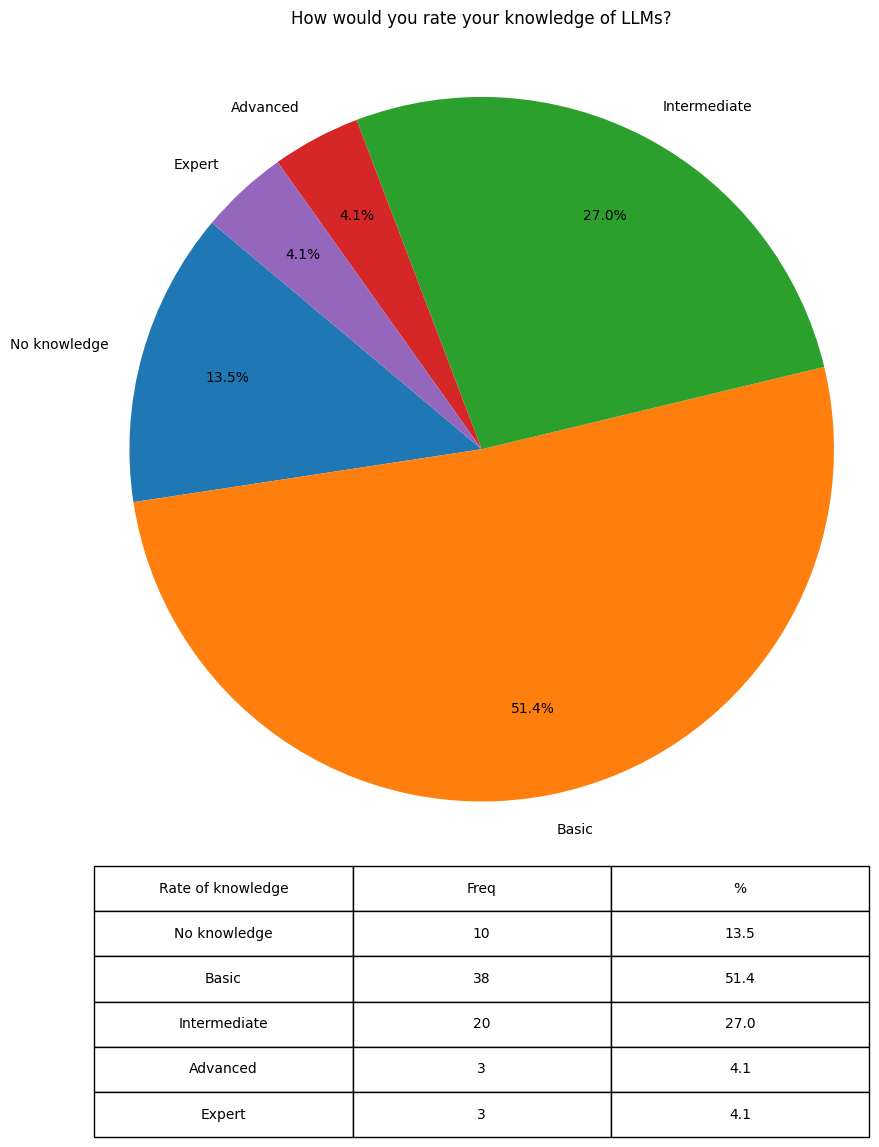

In [47]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = question_sts['qtde']
labels = question_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('How would you rate your knowledge of LLMs?')

# Adjusting the position and size of the table
table_data = question_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Rate of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q17 - Which LLMs have you used or are familiar with?
- GPT by OpenAI
- Gemini by Google
- Orca or Phi-1 by Microsoft
- Llama by Meta
- Falcon by TII UAE
- Mixtral 7B by Mistral AI
- Claude by Anthropic
- StableLM 2 by Stability AI
- Coral by Cohere
- XGen-7B by Salesforce
- Sabiá by Maritaca AI
- BERTimbau by Neuralmind
- Cabrita
- BERTaú by Itaú
- Bloom by BigScience
- Grok by xAI
- Other

In [56]:
column_name = "17. Quais LLMs você já utilizou ou está familiarizado? (Marque todas as opções que se aplicam)"
result_q17 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'GPT da OpenAI':'GPT by OpenAI',
    'Gemini da Google':'Gemini by Google',
    'Orca ou Phi-1 da Microsoft':'Orca or Phi-1 by Microsoft',
    'Llama da Meta':'Llama by Meta',
    'Falcon da TII UAE':'Falcon by TII UAE',
    'Mixtral 7B da Mistral AI':'Mixtral 7B by Mistral AI',
    'Claude da Anthropic':'Claude by Anthropic',
    'StableLM 2 da Stability AI':'StableLM 2 by Stability AI',
    'Coral da Cohere':'Coral by Cohere',
    'XGen-7B da Salesforce':'XGen-7B by Salesforce',
    'Sabiá da Maritaca AI':'Sabiá by Maritaca AI',
    'BERTimbau da Neuralmind':'BERTimbau by Neuralmind',
    'Cabrita':'Cabrita',
    'BERTaú do Itaú':'BERTaú by Itaú',
    'Bloom da BigScience':'Bloom by BigScience',
    'Grok da xAI':'Grok by xAI',
    'Copilot':'Copilot by Microsoft',
    'Openchat da USP':'Openchat by USP',
    'Copilot da Microsoft':'Copilot by Microsoft',
    'Luzia e POE':'Other',
    '':'Other',
    'Nenhuma':'Other'
}
# Atualizando a coluna com os valores traduzidos
result_q17['answer'] = result_q17['answer'].map(translation_dict)

result_q17.drop('pct', axis=1, inplace=True)

#result_q17 = result_q17['answer'].value_counts().to_frame()
#result_q17 = result_q17.reset_index(drop=False)
#result_q17 = result_q17.rename(columns={'index': 'question_anwser'})

#result_q17 = result_q17.sort_values(by='answer', ascending=True)
#result_q17 = result_q17.reset_index(drop=True)

# Agrupar por 'answer' e somar as quantidades
result_q17 = result_q17.groupby('answer', as_index=False).sum()

result_q17['pct'] = ((result_q17['qtde']/df.shape[0])*100).round(1)

#result_q17

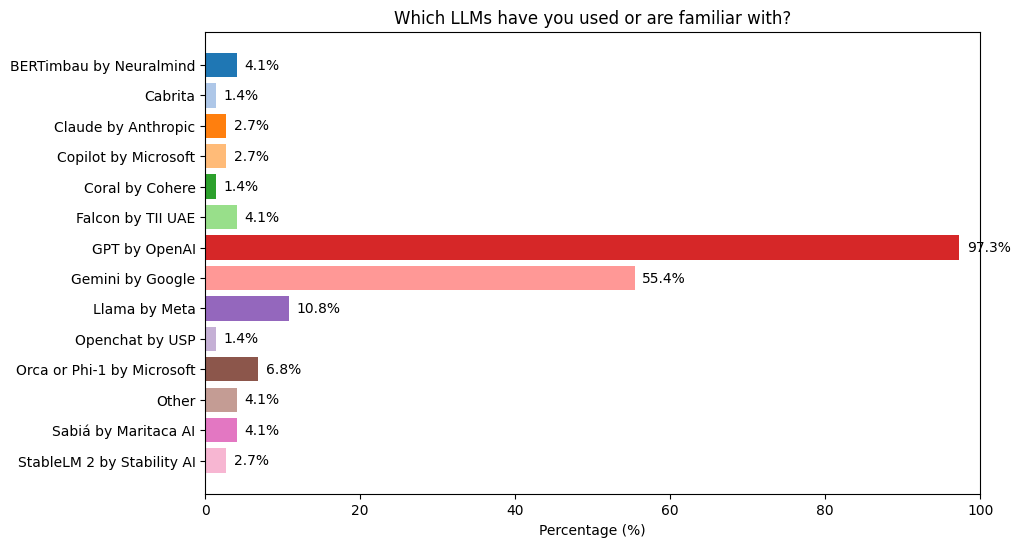

,LGPD data protection concepts,Freq,%
0,BERTimbau by Neuralmind,3,4.1
1,Cabrita,1,1.4
2,Claude by Anthropic,2,2.7
3,Copilot by Microsoft,2,2.7
4,Coral by Cohere,1,1.4
5,Falcon by TII UAE,3,4.1
6,GPT by OpenAI,72,97.3
7,Gemini by Google,41,55.4
8,Llama by Meta,8,10.8
9,Openchat by USP,1,1.4


In [57]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q17)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q17['answer'], result_q17['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q17['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Which LLMs have you used or are familiar with?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q17[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LGPD data protection concepts", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q18 - Have you ever attended training or courses on LLMs?
- I have never participated
- I have participated in an introductory training
- I have participated in a basic course
- I have participated in an intermediate course
- I have participated in an advanced or specialization training

In [60]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q18_sts = df["18. Você já participou de treinamentos ou cursos sobre LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q18_sts = q18_sts.reset_index(drop=False)
q18_sts = q18_sts.rename(columns={'index': 'question_anwser'})


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Nunca participei': 1,
                'Participei de um treinamento introdutório': 2,
                'Participei de um curso básico': 3,
                'Participei de um curso intermediário': 4,
                'Participei de um treinamento avançado ou especialização': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q18_sts['ord_question_anwser'] = q18_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q18_sts = q18_sts.sort_values(by='ord_question_anwser', ascending=True)
q18_sts.drop('ord_question_anwser', axis=1, inplace=True)
q18_sts = q18_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q18_sts.rename(columns={'18. Você já participou de treinamentos ou cursos sobre LLMs? ': 'qtde'}, inplace=True)
q18_sts['pct'] = ((q18_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {
    'Nunca participei': 'Never participated',
    'Participei de um treinamento introdutório': 'Introductory training',
    'Participei de um curso básico': 'Basic course',
    'Participei de um curso intermediário': 'Intermediate course',
    'Participei de um treinamento avançado ou especialização': 'Advanced or specialization training'
    }
# Atualizando a coluna com os valores traduzidos
q18_sts['question_anwser'] = q18_sts['question_anwser'].map(translation_dict)

#q18_sts

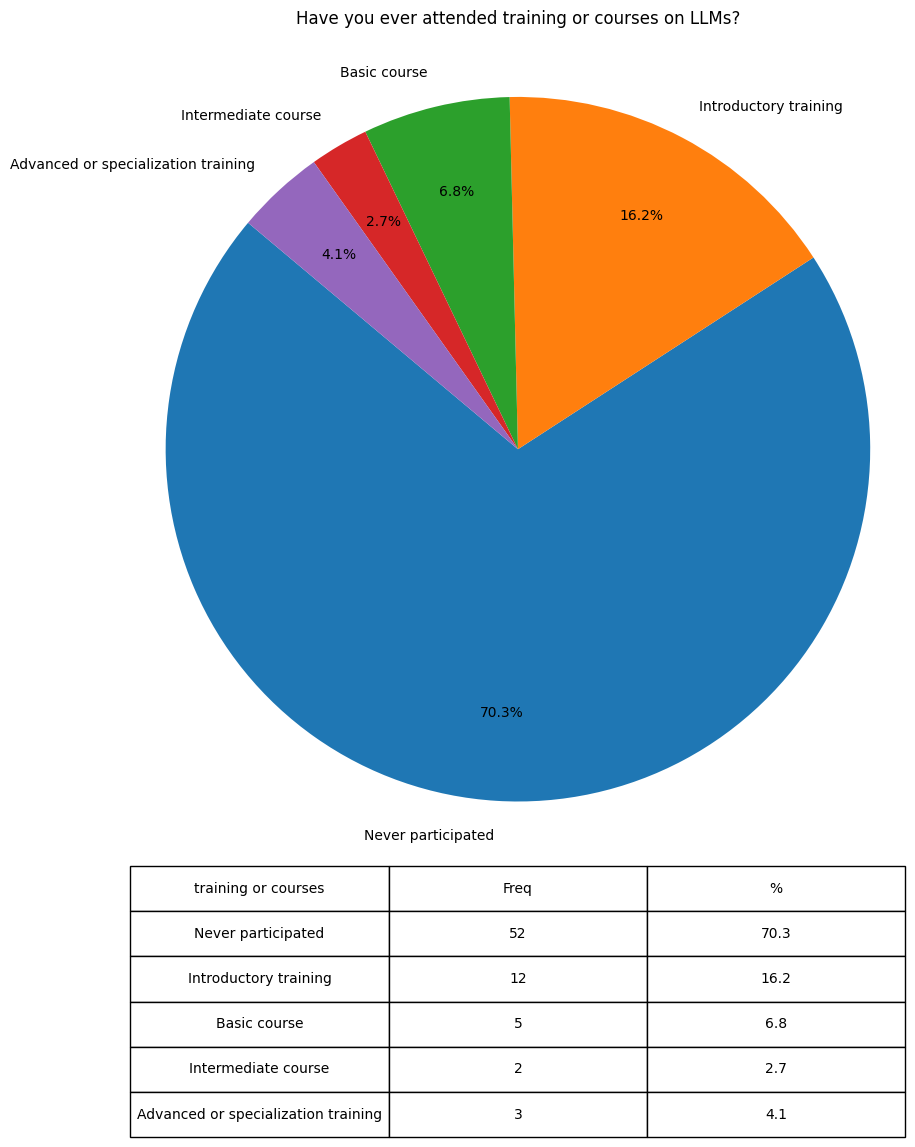

In [59]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q18_sts['qtde']
labels = q18_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Have you ever attended training or courses on LLMs?')

# Adjusting the position and size of the table
table_data = q18_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "training or courses", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q19 - How do you use LLMs in your professional activities?
open question

In [79]:
# Creating a DataFrame with a specific column related to data privacy
df_filtered = df['19. Como você utiliza LLMs em suas atividades profissionais?'].to_frame()

# Dropping rows with missing values in the specified column
df_filtered = df_filtered.dropna(subset=['19. Como você utiliza LLMs em suas atividades profissionais?'])

# Resetting the index of the DataFrame after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent
df_filtered = df_filtered.rename(columns={'19. Como você utiliza LLMs em suas atividades profissionais?': 
                        '15. How do you use LLMs in your professional activities?'})

df_filtered

,15. How do you use LLMs in your professional activities?
0,"Tradução, apoio para analise e apoio na revisão de texto."
1,Não uso
2,"me auxilia com comandos de SO, coisas que não uso com frequência. As vezes é mais efetivo que no google, porém nem sempre é acertivo"
3,Correção de texto
4,Via sites do Copilot ou Chatgpt
5,"Pesquisas, estudos e apoio na construção de soluções"
6,Para ganhar produtividade na pesquisa e para auxiliar na codificação de lógicas de algoritmos.
7,Apenas estudando o que se é possível dentro das aplicações que apoio o desenvolvimento.
8,Apoio na formulação de idéias ou retirada de dúvidas.
9,"Utilizo o copilot que é homologado pela empresa que trabalho, nele normalmente tiro algumas dúvidas comuns que eu tiraria até em um stackoverflow... geração de textos, geração de conteúdos educacionais ajudam muito tbm."


### Q20 - In your opinion, do you have a good understanding of the capabilities and limitations of LLMs?
- No knowledge
- Basic Awareness  (I have a general idea of some of the basic capabilities and limitations of LLMs)
- Basic knowledge (I understand the main capabilities and limitations of LLMs, but I still have questions about some aspects)
- Intermediate Knowledge (I have a good understanding of the capabilities and limitations of LLMs, including their applications and challenges)
- Comprehensive Knowledge (I have mastery of the topic, with in-depth knowledge of the capabilities, limitations and implications of LLMs)

In [56]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q20_sts = df["20. Na sua opinião, você possui um bom entendimento das capacidades e limitações dos LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q20_sts = q20_sts.reset_index(drop=False)
q20_sts = q20_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q20_sts["question_anwser"] = q20_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não tenho conhecimento': 1,
                'Noções básicas': 2,
                'Conhecimento moderado': 3,
                'Conhecimento bom': 4,
                'Conhecimento completo': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q20_sts['ord_question_anwser'] = q20_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q20_sts = q20_sts.sort_values(by='ord_question_anwser', ascending=True)
q20_sts.drop('ord_question_anwser', axis=1, inplace=True)
q20_sts = q20_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q20_sts.rename(columns={'20. Na sua opinião, você possui um bom entendimento das capacidades e limitações dos LLMs? ': 'qtde'}, inplace=True)
q20_sts['pct'] = ((q20_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {
    'Não tenho conhecimento':'No knowledge',
    'Noções básicas':'Basic Awareness',
    'Conhecimento moderado':'Basic knowledge',
    'Conhecimento bom':'Intermediate Knowledge',
    'Conhecimento completo':'Comprehensive Knowledge'
    }
# Atualizando a coluna com os valores traduzidos
q20_sts['question_anwser'] = q20_sts['question_anwser'].map(translation_dict)

#q20_sts

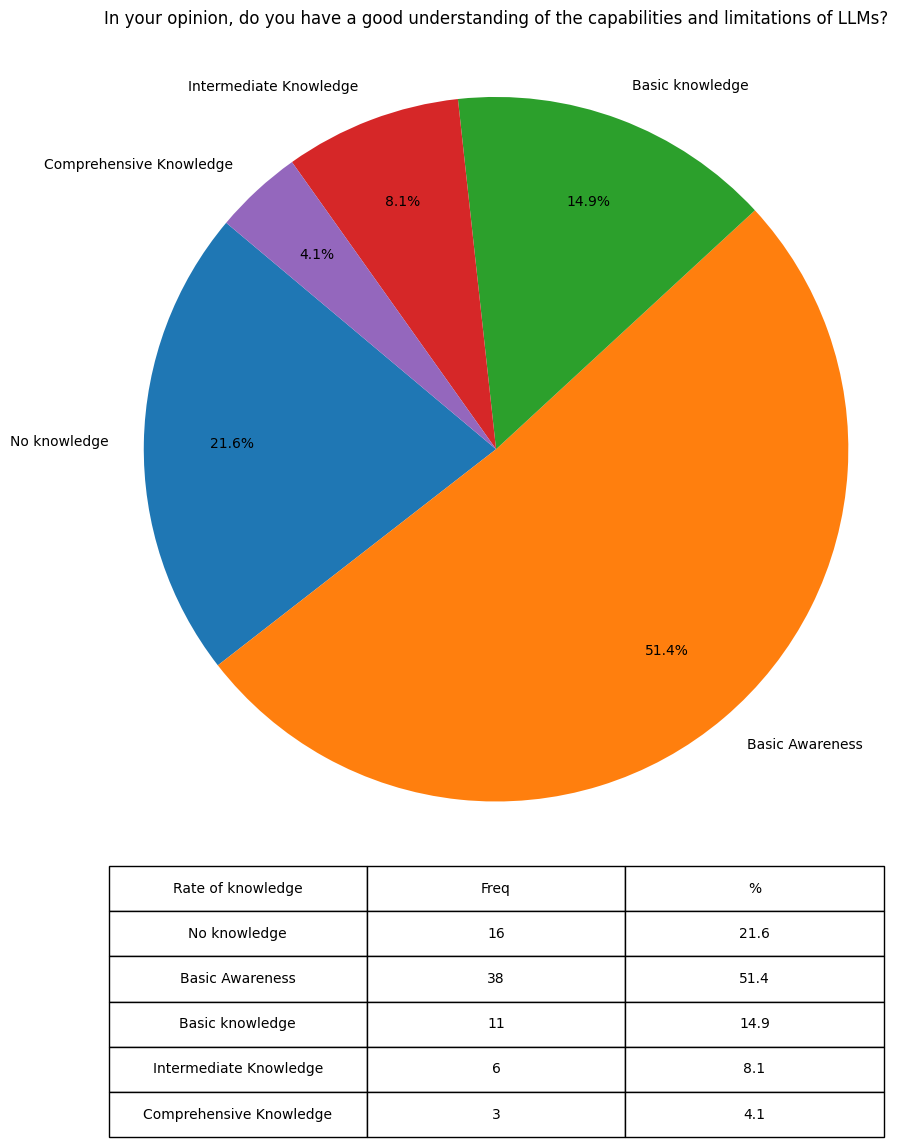

In [55]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q20_sts['qtde']
labels = q20_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('In your opinion, do you have a good understanding of the capabilities and limitations of LLMs?')

# Adjusting the position and size of the table
table_data = q20_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Rate of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q21 - Which of the following LLM applications do you know or have used?
- Text generation
- Machine translation
- Question answering
- Text summaries
- Text analysis
- Sentiment analysis
- Chatbots and virtual assistants
- Content creation
- Coding and programming
- Research and data analysis
- Other

In [66]:
column_name = "21. Quais das seguintes aplicações de LLMs você conhece ou já utilizou? (Marque todas as opções que se aplicam)"
result_q21 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Geração de texto.':'Text generation',
    'Tradução automática.':'Machine translation',
    'Respostas a perguntas':'Question answering',
    'Resumos de texto.':'Text summaries',
    'Análise de texto':'Text analysis',
    'Análise de sentimento.':'Sentiment analysis',
    'Chatbots e assistentes virtuais':'Chatbots and virtual assistants',
    'Criação de conteúdo':'Content creation',
    'Codificação e programação.':'Coding and programming',
    'Pesquisa e análise de dados':'Research and data analysis',
    'Talvez tradução e chatbots com os quais interagi':'Other'
}
# Atualizando a coluna com os valores traduzidos
result_q21['answer'] = result_q21['answer'].map(translation_dict)

result_q21 = result_q21.sort_values(by='answer', ascending=True)
result_q21 = result_q21.reset_index(drop=True)


#result_q21

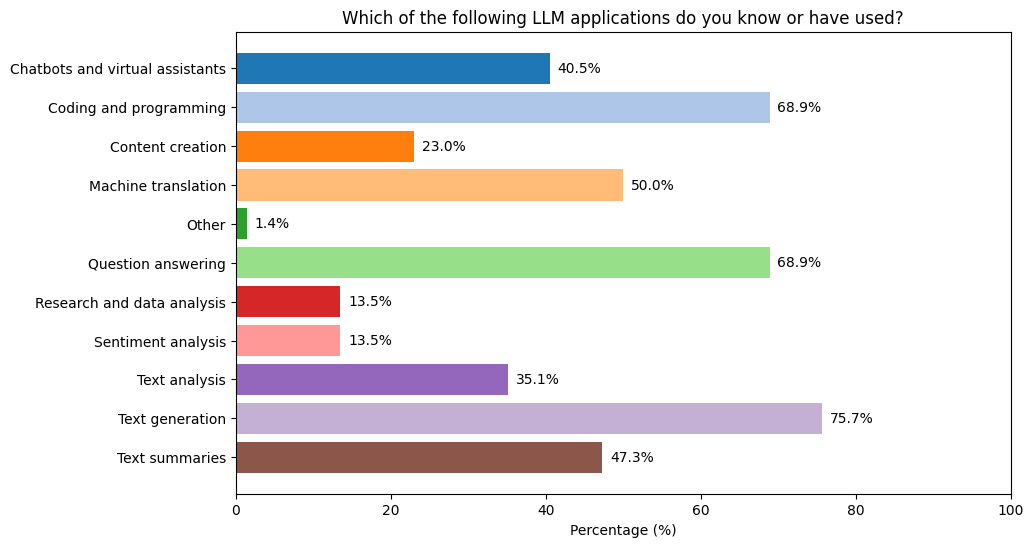

,LGPD data protection concepts,Freq,%
0,Chatbots and virtual assistants,30,40.5
1,Coding and programming,51,68.9
2,Content creation,17,23.0
3,Machine translation,37,50.0
4,Other,1,1.4
5,Question answering,51,68.9
6,Research and data analysis,10,13.5
7,Sentiment analysis,10,13.5
8,Text analysis,26,35.1
9,Text generation,56,75.7


In [65]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q21['answer'], result_q21['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q21['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Which of the following LLM applications do you know or have used?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q21[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LGPD data protection concepts", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

## RQ3 - What is the level of understanding of Brazilian software developers about the data privacy risks associated with the use of LLMs in their professional activities?


### Q22 - How aware are you of the privacy risks associated with the use of LLMs?
- No knowledge
- Basic Awareness (I have a general idea of the risks)
- Basic knowledge (I understand the main risks and their impacts)
- Intermediate Knowledge (I can explain the risks in detail and with examples)
- Comprehensive Knowledge (I have mastered the topic and can discuss the nuances and implications)

In [60]:
result_q22 = process_level_knowledge_column(df, "22. Qual o seu nível de conhecimento sobre os riscos à privacidade associados ao uso de LLMs? ")
#result_q22

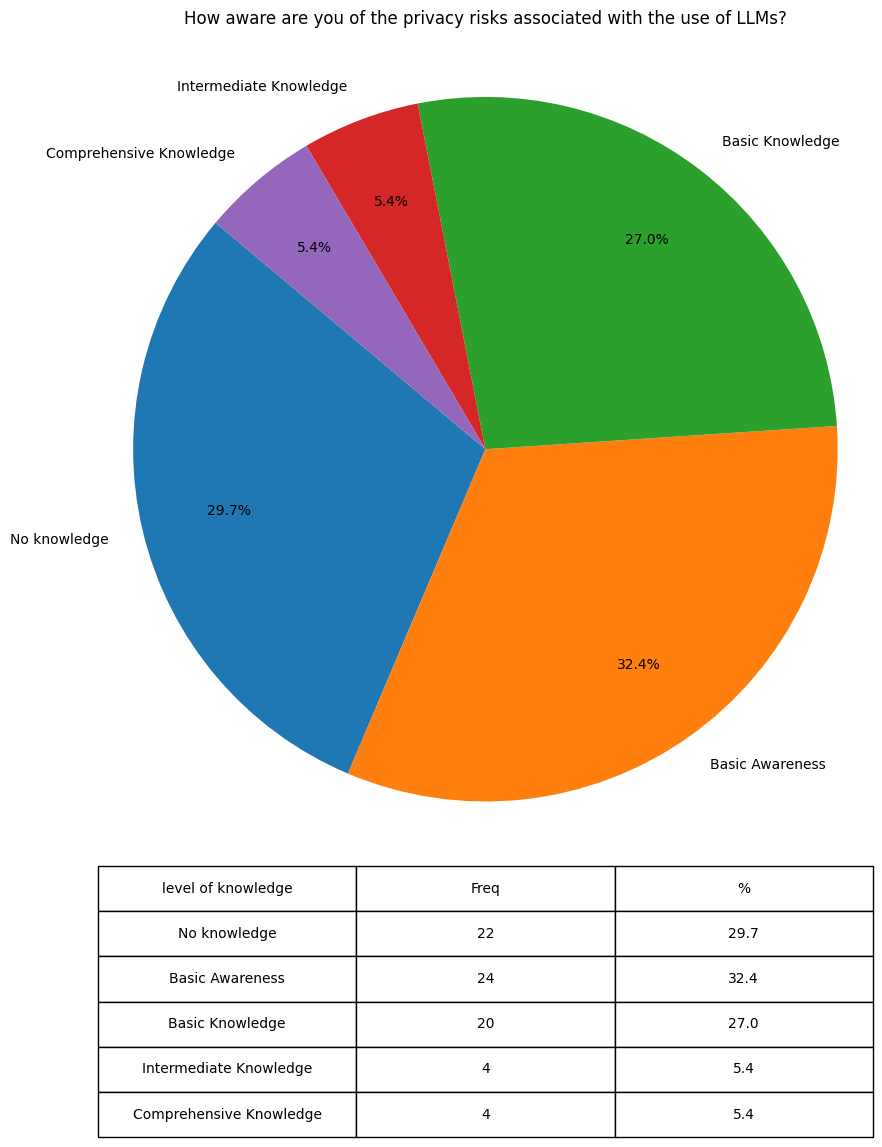

In [59]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q22['qtde']
labels = result_q22['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('How aware are you of the privacy risks associated with the use of LLMs?')

# Adjusting the position and size of the table
table_data = result_q22[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of knowledge", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q23 - Which of the following privacy risks do you associate with the use of LLMs?
- Leakage of sensitive data
- Misuse of personal information
- Exposure to cyberattacks
- Unauthorized disclosure of personal information
- Lack of control over data used
- Difficulty in ensuring compliance with privacy regulations
- Risks of bias and discrimination
- Inadequate data storage
- Failures in data anonymization
- Unauthorized access to data
- Failures in implementing privacy policies
- Misuse of data by third parties
- Lack of transparency about data use
- Lack of control over shared data
- Collection and analysis of personal data without consent
- Other

In [78]:
column_name = "23. Quais dos seguintes riscos à privacidade você associa ao uso de LLMs? (Marque todos que se aplicam)"
result_q23 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Vazamento de dados sensíveis':'Leakage of sensitive data',
    'Uso indevido de informações pessoais':'Misuse of personal information',
    'Exposição a ataques cibernéticos':'Exposure to cyberattacks',
    'Exposição de informações pessoais não autorizadas':'Unauthorized disclosure of personal information',
    'Falta de controle sobre os dados utilizados':'Lack of control over data used',
    'Dificuldade em garantir a conformidade com regulamentações de privacidade':'Difficulty in ensuring compliance with privacy regulations',
    'Riscos de viés e discriminação':'Risks of bias and discrimination',
    'Armazenamento inadequado de dados':'Inadequate data storage',
    'Falhas na anonimização de dados':'Failures in data anonymization',
    'Acesso não autorizado aos dados':'Unauthorized access to data',
    'Falhas na implementação de políticas de privacidade':'Failures in implementing privacy policies',
    'Uso indevido de dados por terceiros':'Misuse of data by third parties',
    'Falta de transparência sobre o uso dos dados':'Lack of transparency about data use',
    'Falta de controle sobre os dados compartilhados':'Lack of control over shared data',
    'Coleta e análise de dados pessoais sem consentimento':'Collection and analysis of personal data without consent',
    'Reprodução velada de vieses e preconceitos humanos. Alguém pode crer que a IA é imparcial, e aceitar decisões automatizadas mesmo que estejam equivocadas por conta de como a IA foi treinada':'Other',
    'Possível venda de dados a entes governamentais':'Other'
}
# Atualizando a coluna com os valores traduzidos
result_q23['answer'] = result_q23['answer'].map(translation_dict)

result_q23.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q23 = result_q23.groupby('answer', as_index=False).sum()


result_q23['pct'] = ((result_q23['qtde']/df.shape[0])*100).round(1)

result_q23 = result_q23.sort_values(by='answer', ascending=True)
result_q23 = result_q23.reset_index(drop=True)


#result_q23

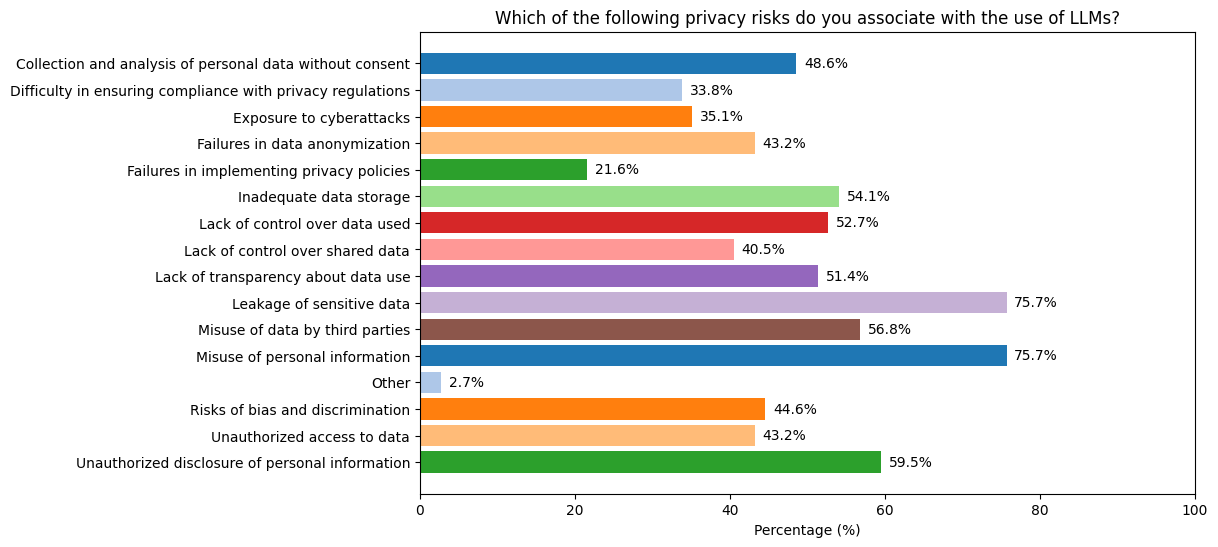

,LGPD data protection concepts,Freq,%
0,Collection and analysis of personal data without consent,36,48.6
1,Difficulty in ensuring compliance with privacy regulations,25,33.8
2,Exposure to cyberattacks,26,35.1
3,Failures in data anonymization,32,43.2
4,Failures in implementing privacy policies,16,21.6
5,Inadequate data storage,40,54.1
6,Lack of control over data used,39,52.7
7,Lack of control over shared data,30,40.5
8,Lack of transparency about data use,38,51.4
9,Leakage of sensitive data,56,75.7


In [77]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q23['answer'], result_q23['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q23['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Which of the following privacy risks do you associate with the use of LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q23[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LGPD data protection concepts", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q24 - What are the main privacy risks you associate with the use of LLMs? 
Open Question

In [81]:
# Creating a DataFrame with a specific column related to data privacy
df_filtered = df['24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? '].to_frame()

# Dropping rows with missing values in the specified column
df_filtered = df_filtered.dropna(subset=['24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? '])

# Resetting the index of the DataFrame after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent
df_filtered = df_filtered.rename(columns={'24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? ': 
                        '24. What are the main privacy risks you associate with the use of LLMs?'})

df_filtered

,24. What are the main privacy risks you associate with the use of LLMs?
0,"Viés algorítmico, discriminação, ciberadicao, controle social, fraude, falta de transparência, exposição e tratamento ilegítimo de dados pessoais."
1,"Podem inadvertidamente revelar dados confidenciais, admitir acesso não autorizados e violação de privacidade e segurança."
2,"A possibilidade de vazamento de dados que possam trazer transtornos, perseguições, cancelamentos e coisas do tipo"
3,Não pensei sobre isso
4,Vazamento de dados sensíveis ou seu tratamento sem autorização.
5,Utilização de dados pessoas sem a devida autorização
6,O envio de dados a plataformas de terceiros que poder um nível de segurança desconhecido ou ainda os próprios dados podem ser utilizados para finalidades distintas ao que se deseja.
7,Falta de controle sobre os dados utilziados
8,Engenharia social
9,O usuário fornecer dados sensíveis aos modelos LLM


### Q25 - In your opinion, what is the level of privacy risk associated with the use of LLMs in your projects?
- No risk (LLMs pose no risk to data privacy)
- Low risk (LLMs pose minimal privacy risks if used responsibly)
- Moderate risk (LLMs pose some privacy risks, but can be managed with appropriate measures)
- High risk (LLMs pose significant privacy risks and robust control measures are required)
- Very high risk (LLMs pose a significant risk to data privacy and require stringent mitigation measures)

In [86]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q25_sts = df["25. Na sua opinião, qual o nível de risco de privacidade associado ao uso de LLMs em seus projetos?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q25_sts = q25_sts.reset_index(drop=False)
q25_sts = q25_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q25_sts["question_anwser"] = q25_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Sem risco': 1,
                'Risco baixo': 2,
                'Risco moderado': 3,
                'Risco alto': 4,
                'Risco muito alto': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q25_sts['ord_question_anwser'] = q25_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q25_sts = q25_sts.sort_values(by='ord_question_anwser', ascending=True)
q25_sts.drop('ord_question_anwser', axis=1, inplace=True)
q25_sts = q25_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q25_sts.rename(columns={'25. Na sua opinião, qual o nível de risco de privacidade associado ao uso de LLMs em seus projetos?': 'qtde'}, inplace=True)
q25_sts['pct'] = ((q25_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Sem risco': 'No risk',
                    'Risco baixo': 'Low risk',
                    'Risco moderado': 'Moderate risk',
                    'Risco alto': 'High risk',
                    'Risco muito alto': 'Very high risk'
    }
# Atualizando a coluna com os valores traduzidos
q25_sts['question_anwser'] = q25_sts['question_anwser'].map(translation_dict)

#q25_sts

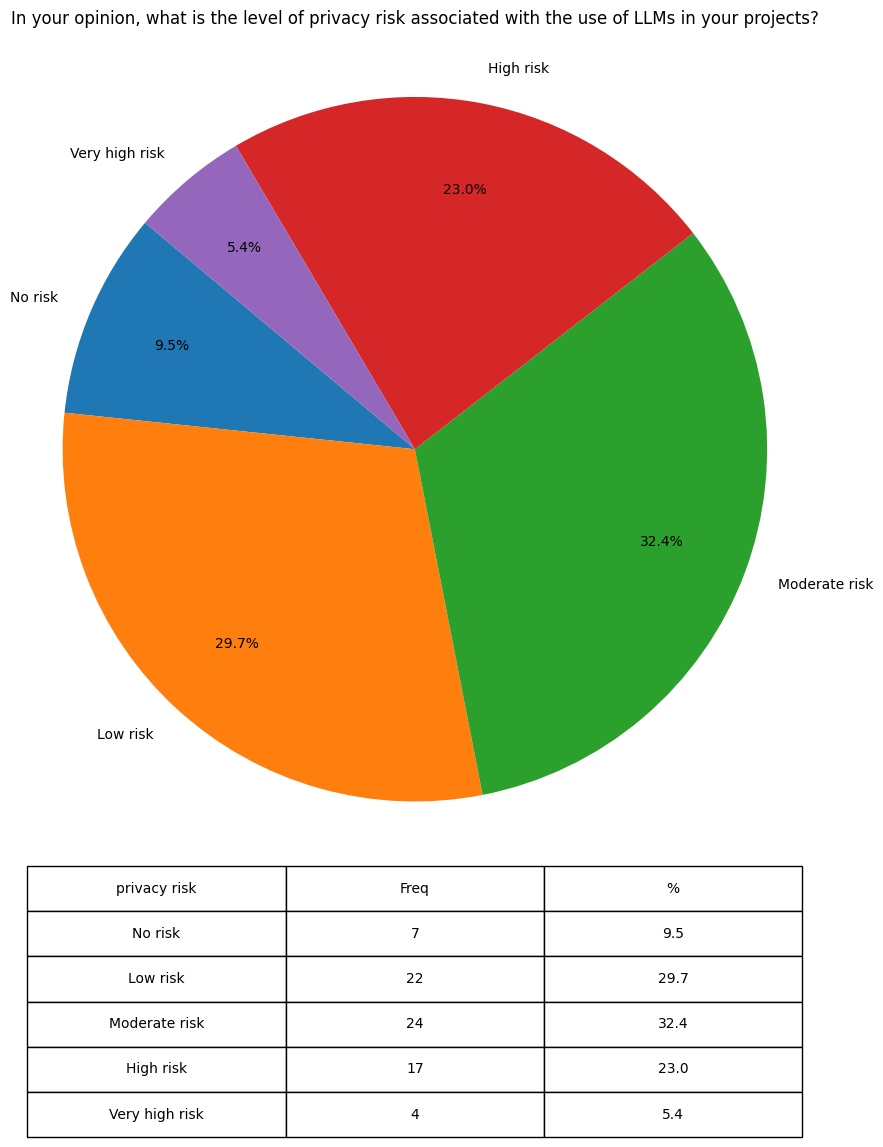

In [85]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q25_sts['qtde']
labels = q25_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('In your opinion, what is the level of privacy risk associated with the use of LLMs in your projects?')

# Adjusting the position and size of the table
table_data = q25_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "privacy risk", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q26 - What is your opinion on training LLMs without compromising data privacy?
- Impossible (Training LLMs will always compromise data privacy to some degree)
- Unlikely (It is unlikely that LLMs can be trained without compromising data privacy, but there are some measures that can mitigate this risk)
- Neutral (I am not sure if LLMs can be trained without compromising data privacy)
- Possible (It is possible to train LLMs without compromising data privacy, but this requires rigorous security techniques and measures)
- Highly Likely (I believe that LLMs can be trained safely and responsibly without compromising data privacy)

In [88]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q26_sts = df["26. Qual sua opinião sobre o treinamento de LLMs sem comprometer a privacidade dos dados?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q26_sts = q26_sts.reset_index(drop=False)
q26_sts = q26_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q26_sts["question_anwser"] = q26_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Impossível': 1,
                'Improvável': 2,
                'Neutro': 3,
                'Possível': 4,
                'Altamente provável': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q26_sts['ord_question_anwser'] = q26_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q26_sts = q26_sts.sort_values(by='ord_question_anwser', ascending=True)
q26_sts.drop('ord_question_anwser', axis=1, inplace=True)
q26_sts = q26_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q26_sts.rename(columns={'26. Qual sua opinião sobre o treinamento de LLMs sem comprometer a privacidade dos dados?': 'qtde'}, inplace=True)
q26_sts['pct'] = ((q26_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Impossível': 'Impossible',
                    'Improvável': 'Unlikely',
                    'Neutro': 'Neutral',
                    'Possível': 'Possible',
                    'Altamente provável': 'Highly Likely'
    }
# Atualizando a coluna com os valores traduzidos
q26_sts['question_anwser'] = q26_sts['question_anwser'].map(translation_dict)

q26_sts

,question_anwser,qtde,pct
0,Impossible,5,6.8
1,Unlikely,15,20.3
2,Neutral,24,32.4
3,Possible,27,36.5
4,Highly Likely,3,4.1


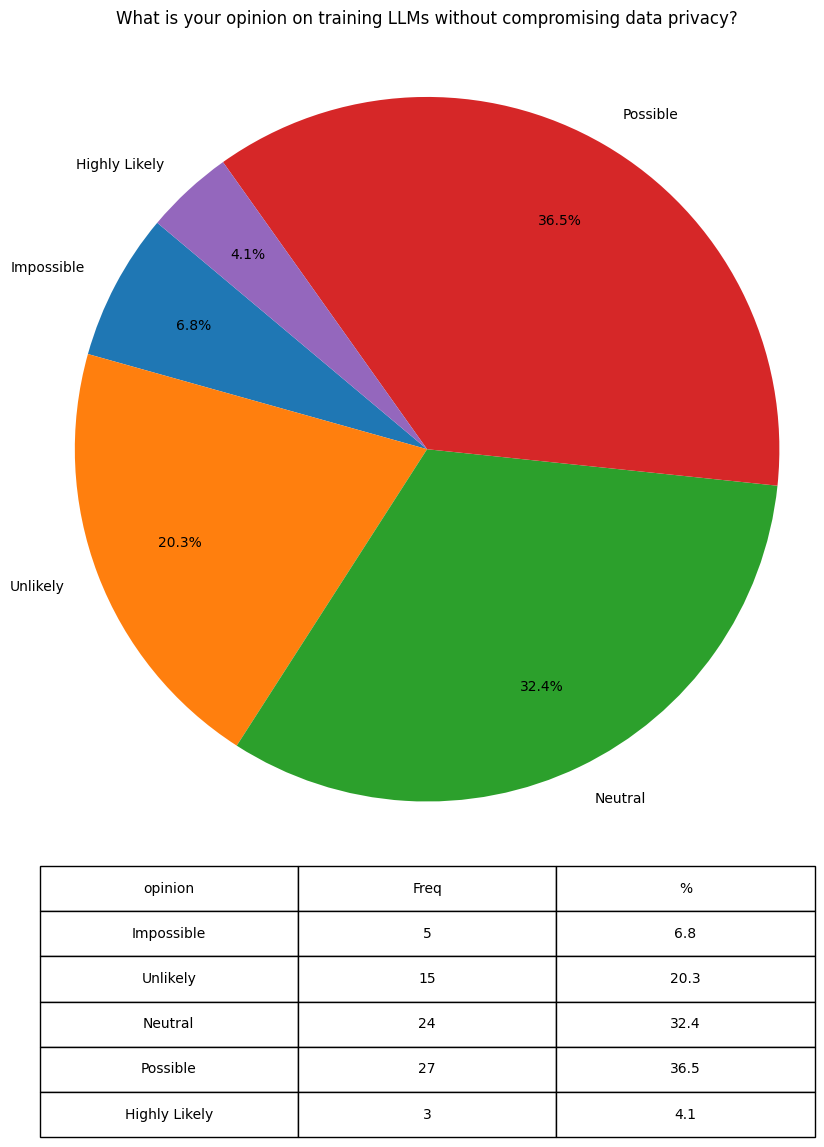

In [91]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q26_sts['qtde']
labels = q26_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('What is your opinion on training LLMs without compromising data privacy?')

# Adjusting the position and size of the table
table_data = q26_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "opinion", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q27 - What types of personal data do you consider most sensitive to being processed by Large Language Models (LLMs)?
- Personally identifiable information (information that allows you to identify yourself)
- Demographic data
- Health and well-being data
- Financial data
- Location data
- Behaviour and browsing data
- Minority group data
- Belief and opinion data
- Children and adolescent data
- Other

In [95]:
column_name = "27. Quais tipos de dados pessoais você considera mais sensíveis ao serem processados por Large Language Models (LLMs)? (Marque todas as opções que se aplicam)"
result_q27 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Dados de identificação pessoal (informações que permitem identificação pessoal)':'Personally identifiable information (information that allows you to identify yourself)',
    'Dados demográficos':'Demographic data',
    'Dados de saúde e bem-estar':'Health and well-being data',
    'Dados financeiros':'Financial data',
    'Dados de localização':'Location data',
    'Dados de comportamento e navegação':'Behaviour and browsing data',
    'Dados de grupos minoritários':'Minority group data',
    'Dados de crenças e opiniões':'Belief and opinion data',
    'Dados de crianças e adolescentes':'Children and adolescent data',
    '':'',
    'Os dados sensíveis estão definidos na lei, não cabe a opinião da pessoa. Faltou incluir aí a biometria.':'Other'
}
# Atualizando a coluna com os valores traduzidos
result_q27['answer'] = result_q27['answer'].map(translation_dict)

#result_q27.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
#result_q27 = result_q27.groupby('answer', as_index=False).sum()


#result_q27['pct'] = ((result_q27['qtde']/df.shape[0])*100).round(1)

result_q27 = result_q27.sort_values(by='answer', ascending=True)
result_q27 = result_q27.reset_index(drop=True)


#result_q27

,answer,qtde,pct
0,Behaviour and browsing data,29,39.2
1,Belief and opinion data,40,54.1
2,Children and adolescent data,48,64.9
3,Demographic data,13,17.6
4,Financial data,54,73.0
5,Health and well-being data,39,52.7
6,Location data,46,62.2
7,Minority group data,21,28.4
8,Other,1,1.4
9,Personally identifiable information (information that allows you to identify yourself),64,86.5


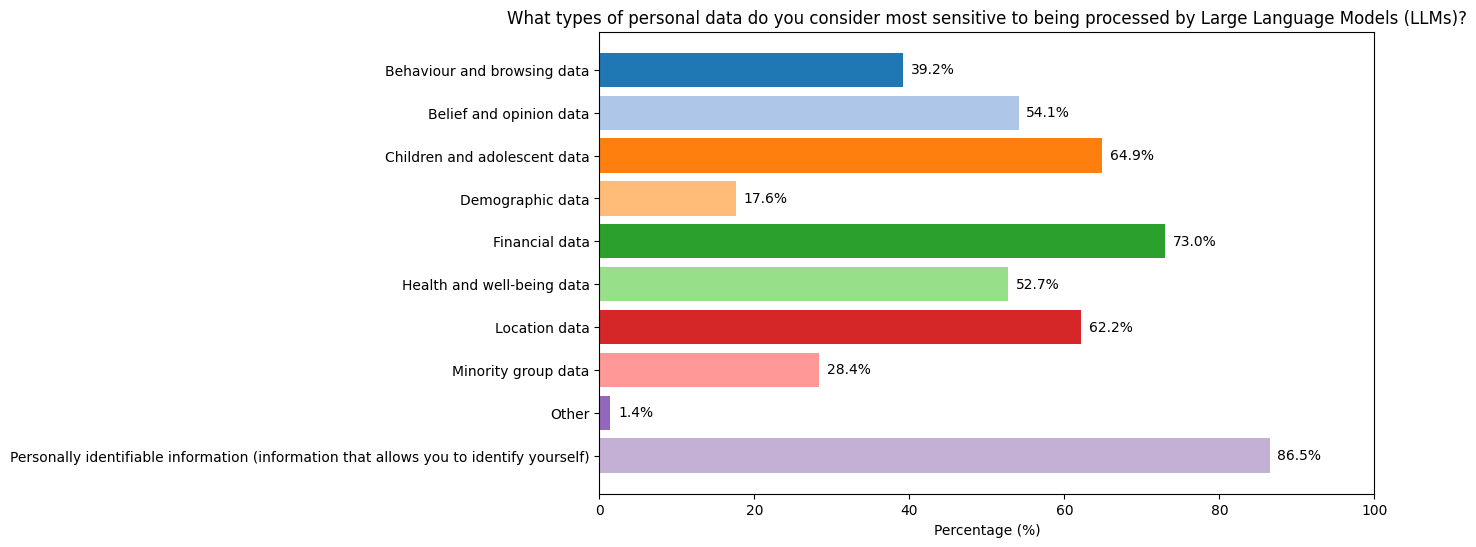

,personal data,Freq,%
0,Behaviour and browsing data,29,39.2
1,Belief and opinion data,40,54.1
2,Children and adolescent data,48,64.9
3,Demographic data,13,17.6
4,Financial data,54,73.0
5,Health and well-being data,39,52.7
6,Location data,46,62.2
7,Minority group data,21,28.4
8,Other,1,1.4
9,Personally identifiable information (information that allows you to identify yourself),64,86.5


In [96]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q27['answer'], result_q27['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q27['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('What types of personal data do you consider most sensitive to being processed by Large Language Models (LLMs)?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q27[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "personal data", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q28 - How do you assess the likelihood of data breaches occurring related to the use of LLMs?
- Very Low (I believe that it is extremely unlikely that data breaches related to the use of LLMs will occur)
- Low (I believe that it is unlikely that data breaches related to the use of LLMs will occur)
- Moderate (I believe that the likelihood of data breaches related to the use of LLMs is moderate)
- High (I believe that it is likely that data breaches related to the use of LLMs will occur)
- Very High (I believe that it is very likely that data breaches related to the use of LLMs will occur)

In [100]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q28_sts = df["28. Qual a sua avaliação da probabilidade de ocorrência de violações de dados relacionadas ao uso de LLMs?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q28_sts = q28_sts.reset_index(drop=False)
q28_sts = q28_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q28_sts["question_anwser"] = q28_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Muito Baixa': 1,
                'Baixa': 2,
                'Moderada': 3,
                'Alta': 4,
                'Muito Alta': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q28_sts['ord_question_anwser'] = q28_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q28_sts = q28_sts.sort_values(by='ord_question_anwser', ascending=True)
q28_sts.drop('ord_question_anwser', axis=1, inplace=True)
q28_sts = q28_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q28_sts.rename(columns={'28. Qual a sua avaliação da probabilidade de ocorrência de violações de dados relacionadas ao uso de LLMs?': 'qtde'}, inplace=True)
q28_sts['pct'] = ((q28_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Muito Baixa': 'Very Low',
                    'Baixa': 'Low',
                    'Moderada': 'Moderate',
                    'Alta': 'High',
                    'Muito Alta': 'Very High'
    }
# Atualizando a coluna com os valores traduzidos
q28_sts['question_anwser'] = q28_sts['question_anwser'].map(translation_dict)

#q28_sts

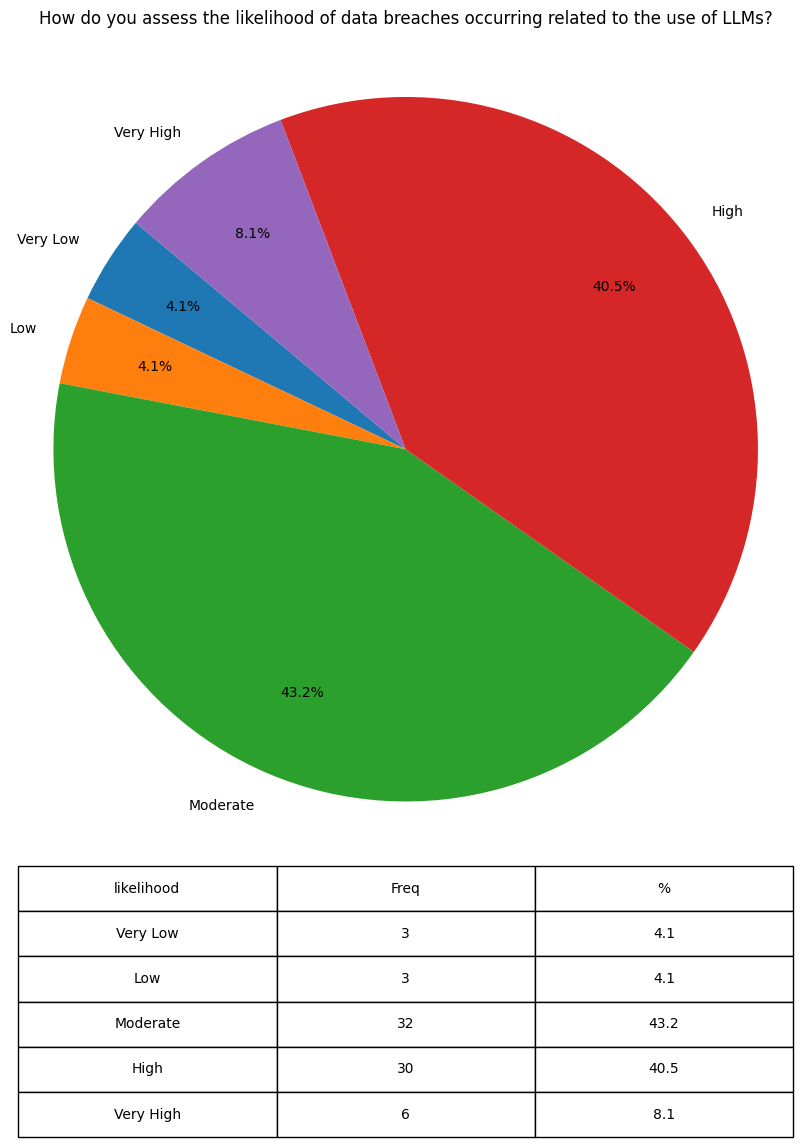

In [99]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q28_sts['qtde']
labels = q28_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('How do you assess the likelihood of data breaches occurring related to the use of LLMs?')

# Adjusting the position and size of the table
table_data = q28_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "likelihood", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q29 - How concerned are you about the impact of data breaches related to the use of LLMs?
- Not at all concerned (I am not concerned about the impact of data breaches on LLMs)
- Somewhat concerned (I am not very concerned about the impact of data breaches on LLMs)
- Moderately concerned (I have some concerns about the impact of data breaches on LLMs, but do not consider it a serious risk)
- Concerned (I am quite concerned about the potential impact of data breaches on LLMs)
- Very concerned (I am extremely concerned about the potential consequences of data breaches on LLMs)

In [104]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q29_sts = df["29. Qual o seu nível de preocupação com o impacto de violações de dados relacionadas ao uso de LLMs?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q29_sts = q29_sts.reset_index(drop=False)
q29_sts = q29_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q29_sts["question_anwser"] = q29_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Nada Preocupado': 1,
                'Pouco Preocupado': 2,
                'Moderadamente Preocupado': 3,
                'Preocupado': 4,
                'Muito Preocupado': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q29_sts['ord_question_anwser'] = q29_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q29_sts = q29_sts.sort_values(by='ord_question_anwser', ascending=True)
q29_sts.drop('ord_question_anwser', axis=1, inplace=True)
q29_sts = q29_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q29_sts.rename(columns={'29. Qual o seu nível de preocupação com o impacto de violações de dados relacionadas ao uso de LLMs?': 'qtde'}, inplace=True)
q29_sts['pct'] = ((q29_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Nada Preocupado': 'Not at all concerned',
                    'Pouco Preocupado': 'Somewhat concerned',
                    'Moderadamente Preocupado': 'Moderately concerned',
                    'Preocupado': 'Concerned',
                    'Muito Preocupado': 'Very concerned'
                   }
# Atualizando a coluna com os valores traduzidos
q29_sts['question_anwser'] = q29_sts['question_anwser'].map(translation_dict)

#q29_sts

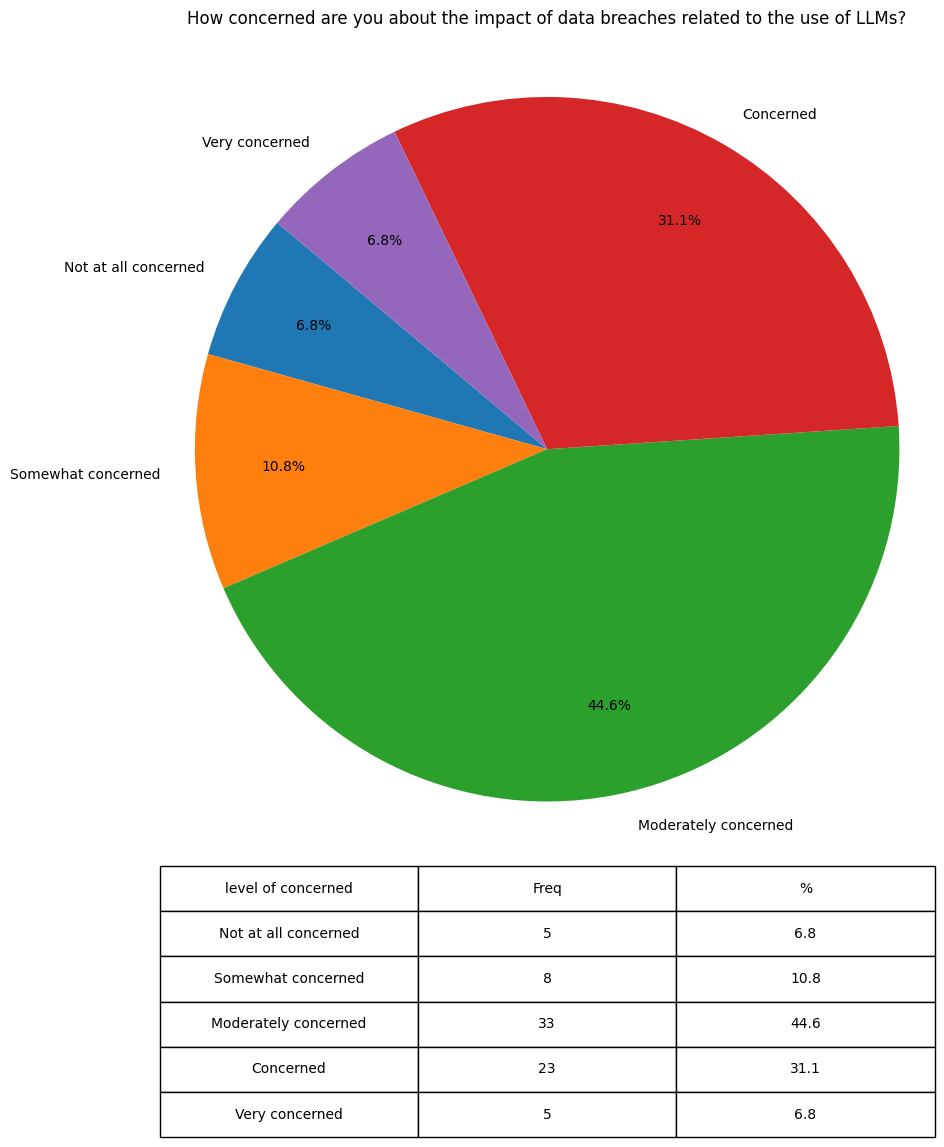

In [105]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q29_sts['qtde']
labels = q29_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('How concerned are you about the impact of data breaches related to the use of LLMs?')

# Adjusting the position and size of the table
table_data = q29_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of concerned", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q30 - What steps do you take to mitigate privacy risks when using LLMs?
Open question

In [108]:
# Creating a DataFrame with a specific column related to data privacy
df_filtered = df['30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? '].to_frame()

# Dropping rows with missing values in the specified column
df_filtered = df_filtered.dropna(subset=['30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? '])

# Resetting the index of the DataFrame after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent
df_filtered = df_filtered.rename(columns={'30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? ': 
                        '30 - What steps do you take to mitigate privacy risks when using LLMs?'})

df_filtered

,30 - What steps do you take to mitigate privacy risks when using LLMs?
0,"Não uso versão gratuita, leio os documentos de política e termos de uso da ferramenta. Evito usar dados pessoais."
1,Mecanismos de segurança de código para proteger contra outros códigos malicioso.
2,escolho bem que tipo de assunto levo a interação junto a uma IA
3,Saber como usar
4,Não informar dados sensíveis às LLMs
5,Regulamentar o funcionamento dos provedores com as responsabilizações necessárias quando for realizado o descumprimento
6,Anonimização dos dados
7,"Simular oq quero fazer, sem passar o dado real"
8,Não sei informar
9,Não inserir informações que não podem ser disseminadas


## RQ4 - What are the practices and procedures adopted by Brazilian software developers to mitigate data privacy risks when using LLMs in their professional activities?


### Q31 - To protect your privacy when using LLMs, do you adopt any specific practices?
- I limit the data I share with LLMs
- I use LLMs from trusted sources
- I check the privacy settings of LLMs
- I monitor how my data is being used by LLMs
- I implement additional security measures, such as data anonymization
- I do not use LLMs for sensitive tasks
- Other

In [121]:
column_name = "31. Para proteger sua privacidade ao usar LLMs, você adota alguma prática específica? (Marque todas as opções que se aplicam)"
result_q31 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Limito os dados que compartilho com LLMs':'I limit the data I share with LLMs',
    'Utilizo LLMs de fontes confiáveis':'I use LLMs from trusted sources',
    'Verifico as configurações de privacidade dos LLMs':'I check the privacy settings of LLMs',
    'Monitoro como meus dados estão sendo utilizados pelos LLMs.':'I monitor how my data is being used by LLMs',
    'Implemento medidas de segurança adicionais, como anonimização de dados':'I implement additional security measures, such as data anonymization',
    'Não utilizo LLMs para tarefas sensíveis':'I do not use LLMs for sensitive tasks'
}
# Atualizando a coluna com os valores traduzidos
result_q31['answer'] = result_q31['answer'].map(translation_dict)

#result_q31.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
#result_q31 = result_q27.groupby('answer', as_index=False).sum()


#result_q27['pct'] = ((result_q27['qtde']/df.shape[0])*100).round(1)

result_q31 = result_q31.sort_values(by='answer', ascending=True)
result_q31 = result_q31.reset_index(drop=True)


#result_q31

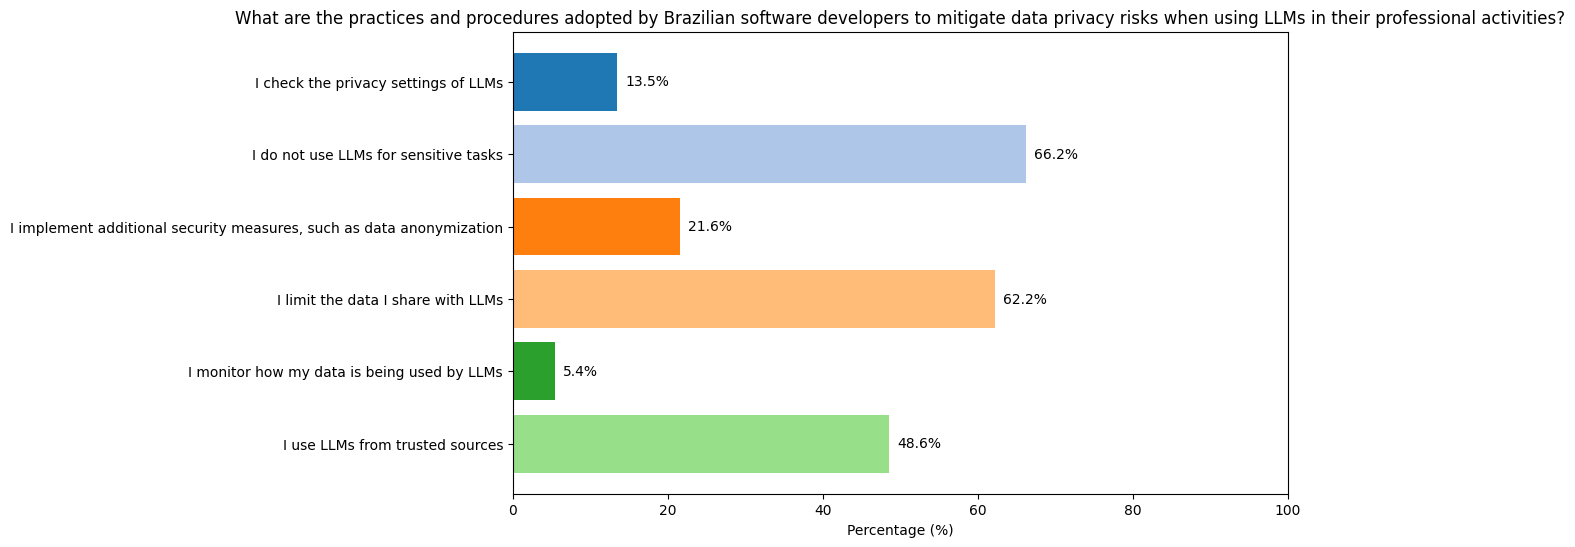

,practices and procedures,Freq,%
0,I check the privacy settings of LLMs,10,13.5
1,I do not use LLMs for sensitive tasks,49,66.2
2,"I implement additional security measures, such as data anonymization",16,21.6
3,I limit the data I share with LLMs,46,62.2
4,I monitor how my data is being used by LLMs,4,5.4
5,I use LLMs from trusted sources,36,48.6


In [120]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q31)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q31['answer'], result_q31['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q31['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('What are the practices and procedures adopted by Brazilian software developers to mitigate data privacy risks when using LLMs in their professional activities?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q31[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "practices and procedures", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

### Q32 - How do you handle sensitive data when using LLMs?
- I do not use LLMs with sensitive data
- I use LLMs with sensitive data only in exceptional cases
- I use LLMs with sensitive data, taking basic precautionary measures, such as anonymization
- I use LLMs in secure and isolated environments, with restricted access and
- I use LLMs with sensitive data only after careful assessment of risks and benefits.

In [137]:
column_name = "32. Como você lida com dados sensíveis ao utilizar LLMs? "
result_q32 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Não utilizo LLMs com dados sensíveis':'I do not use LLMs with sensitive data',
    'Utilizo LLMs com dados sensíveis apenas em casos excepcionais':'I use LLMs with sensitive data only in exceptional cases',
    'Utilizo LLMs com dados sensíveis, tomando medidas de precaução básicas, como anonimização':'I use LLMs with sensitive data, taking basic precautionary measures, such as anonymization',
    'Utilizo LLMs em ambientes seguros e isolados, com acesso restrito e monitoramento rigoroso':'I use LLMs in secure and isolated environments, with restricted access and',
    'Utilizo LLMs com dados sensíveis apenas após cuidadosa avaliação de riscos e benefícios':'I use LLMs with sensitive data only after careful assessment of risks and benefits.'
}
# Atualizando a coluna com os valores traduzidos
result_q32['answer'] = result_q32['answer'].map(translation_dict)

#result_q32.drop('pct', axis=1, inplace=True)

# result_q32 por 'answer' e somar as quantidades
#result_q31 = result_q32.groupby('answer', as_index=False).sum()


#result_q32['pct'] = ((result_q32['qtde']/df.shape[0])*100).round(1)

result_q32 = result_q32.sort_values(by='answer', ascending=True)
result_q32 = result_q32.reset_index(drop=True)


result_q32

,answer,qtde,pct
0,I do not use LLMs with sensitive data,63,85.1
1,"I use LLMs in secure and isolated environments, with restricted access and",1,1.4
2,I use LLMs with sensitive data only in exceptional cases,6,8.1
3,"I use LLMs with sensitive data, taking basic precautionary measures, such as anonymization",4,5.4


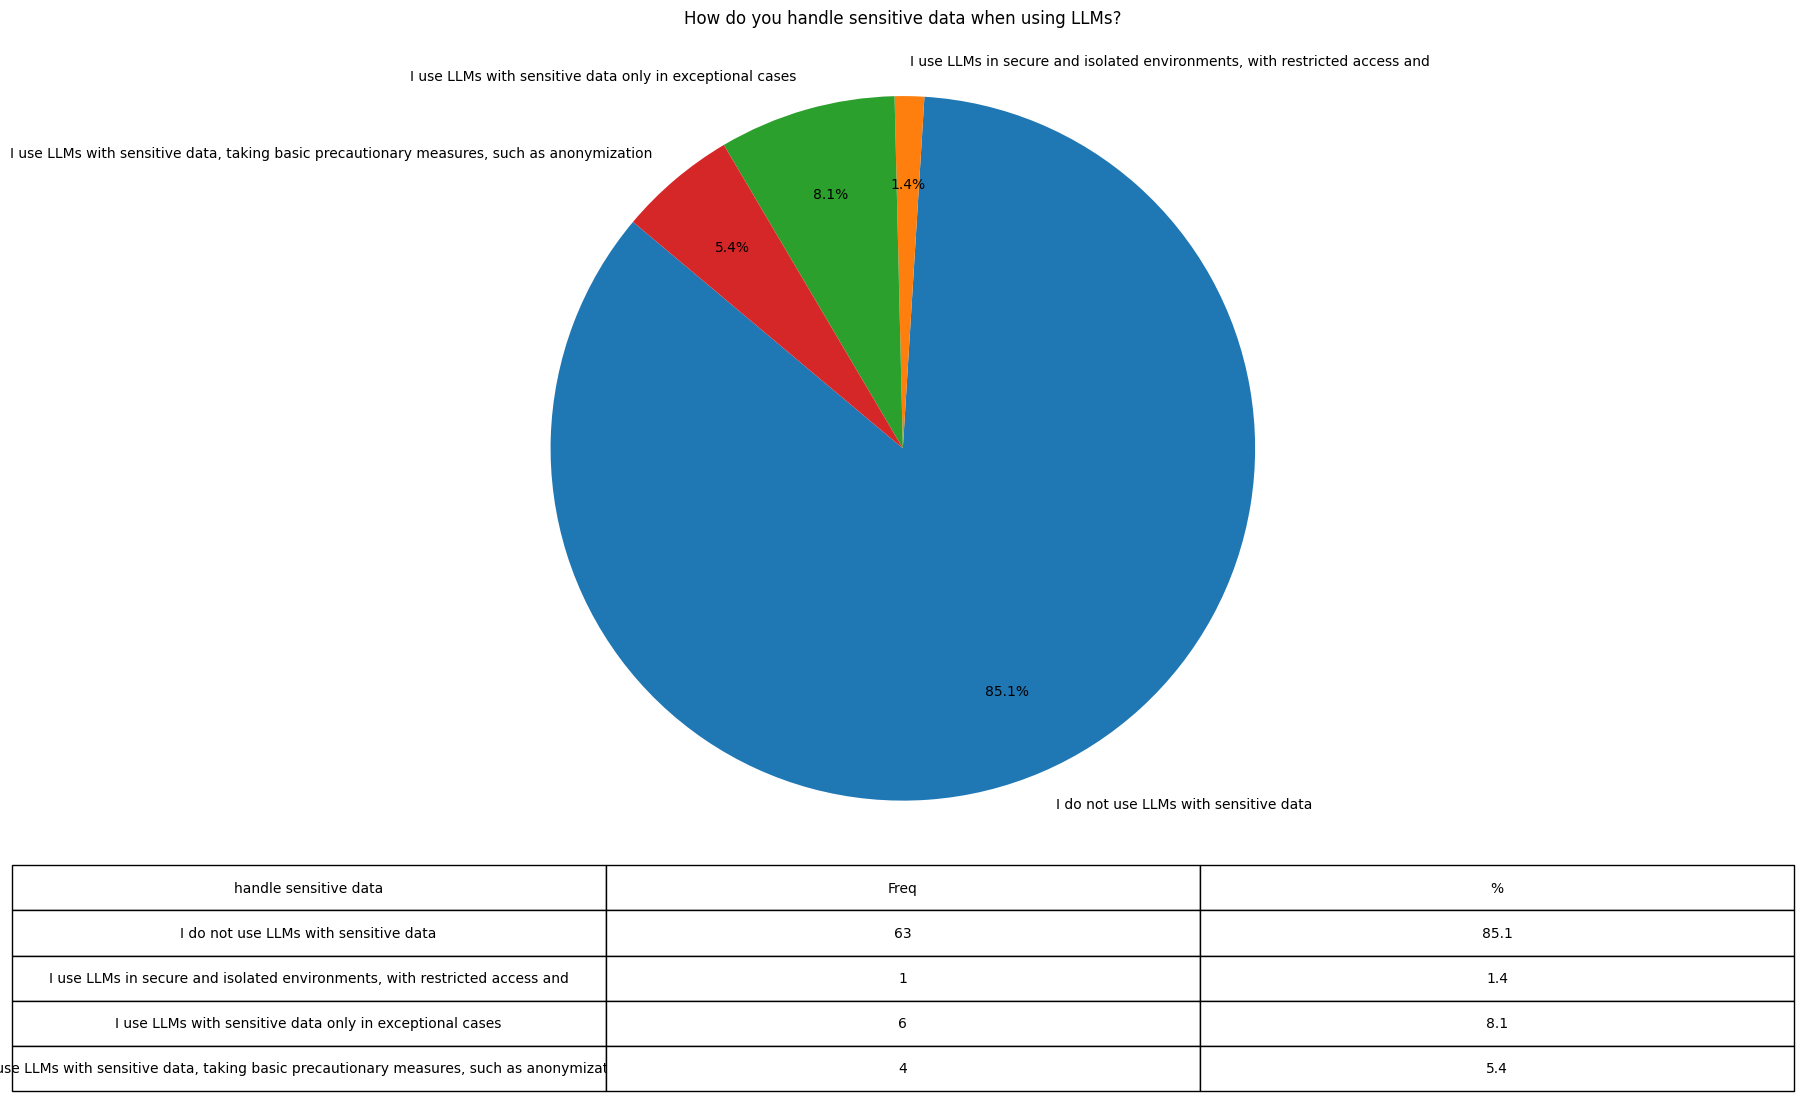

In [134]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q32['qtde']
labels = result_q32['answer']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('How do you handle sensitive data when using LLMs?')

# Adjusting the position and size of the table
table_data = result_q32[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "handle sensitive data", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2.3, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q33 - Before using your data with LLMs, do you take any measures to protect it, such as anonymization or pseudonymization?
- I never anonymize or pseudonymize my data
- I anonymize or pseudonymize some of my data
- I anonymize or pseudonymize most of my data
- I anonymize or pseudonymize all of my data
- I implement complex and customized anonymization/pseudonymization measures

In [136]:
column_name = "33. Antes de utilizar seus dados com LLMs, você toma alguma medida para protegê-los, como anonimização ou pseudonimização? "
result_q33 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Nunca anonimizo ou pseudonimizo meus dados':'I never anonymize or pseudonymize my data',
    'Anonimizo ou pseudonimizo alguns dos meus dados':'I anonymize or pseudonymize some of my data',
    'Anonimizo ou pseudonimizo a maioria dos meus dados':'I anonymize or pseudonymize most of my data',
    'Anonimizo ou pseudonimizo todos os meus dados':'I anonymize or pseudonymize all of my data',
    'Implemento medidas de anonimização/pseudonimização complexas e personalizadas':'I implement complex and customized anonymization/pseudonymization measures'
}
# Atualizando a coluna com os valores traduzidos
result_q33['answer'] = result_q33['answer'].map(translation_dict)

#result_q32.drop('pct', axis=1, inplace=True)

# result_q32 por 'answer' e somar as quantidades
#result_q31 = result_q32.groupby('answer', as_index=False).sum()


#result_q32['pct'] = ((result_q32['qtde']/df.shape[0])*100).round(1)

result_q33 = result_q33.sort_values(by='answer', ascending=True)
result_q33 = result_q33.reset_index(drop=True)


result_q33

,answer,qtde,pct
0,I anonymize or pseudonymize all of my data,15,20.3
1,I anonymize or pseudonymize most of my data,18,24.3
2,I anonymize or pseudonymize some of my data,13,17.6
3,I implement complex and customized anonymization/pseudonymization measures,4,5.4
4,I never anonymize or pseudonymize my data,24,32.4


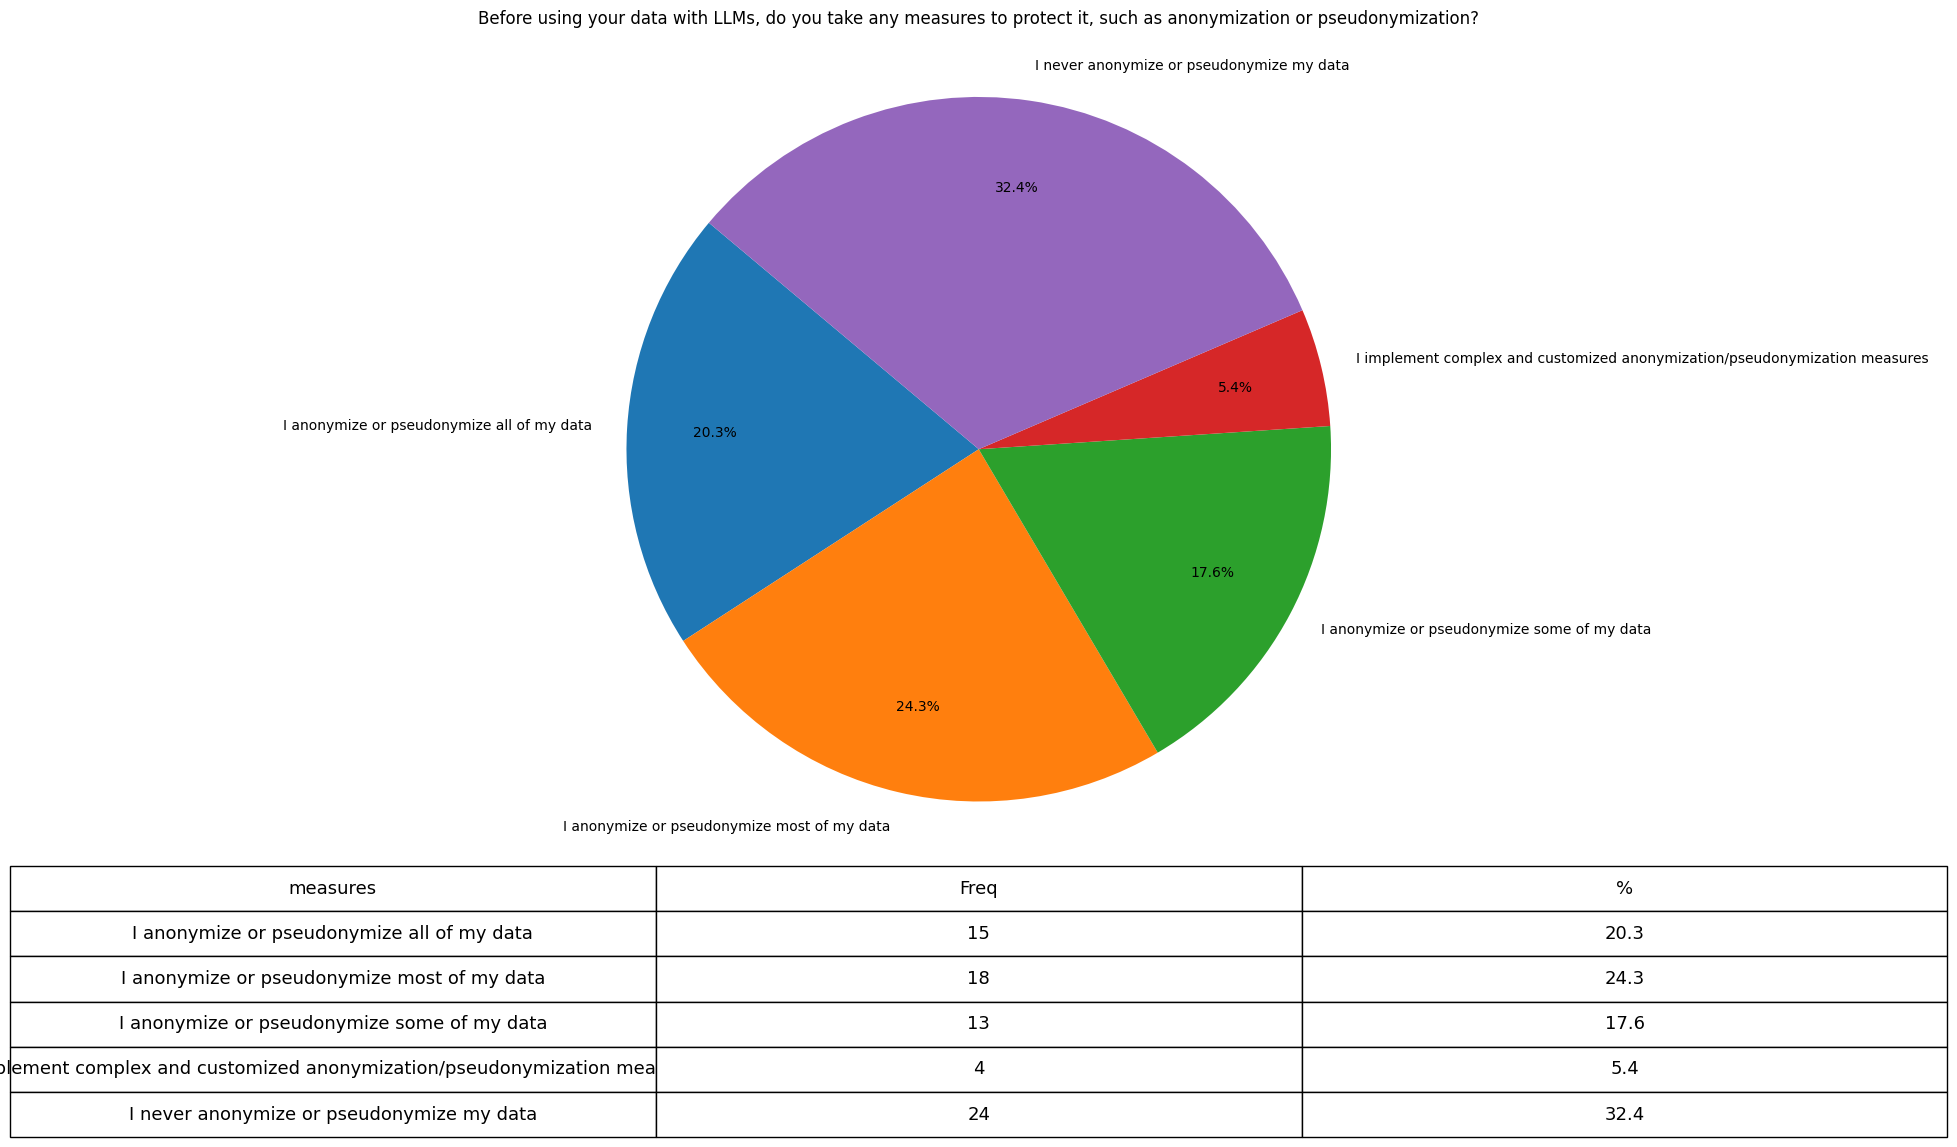

In [135]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q33['qtde']
labels = result_q33['answer']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Before using your data with LLMs, do you take any measures to protect it, such as anonymization or pseudonymization?')

# Adjusting the position and size of the table
table_data = result_q33[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "measures", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(2.5, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q34 - What are the main challenges you face when implementing privacy practices when using LLMs?
- Lack of clarity in privacy guidelines (laws and regulations)
- Challenges in compliance with privacy laws and regulations
- Ethical and legal uncertainties
- Challenges in data anonymization
- Difficulty in identifying and classifying sensitive data
- Limitations of LLM technology to handle sensitive data securely and ethically
- Lack of transparency of LLMs
- Lack of tools and resources in implementing privacy practices with LLMs
- Concerns about security and inappropriate access of sensitive data when using LLMs
- Lack of knowledge and expertise in privacy and LLMs
- Difficulty in measuring the impact of privacy practices
- Lack of awareness and training
- Lack of privacy culture in the organization
- Other

In [161]:
column_name = "Quais os principais desafios que você enfrenta ao implementar práticas de privacidade ao usar LLMs? (Marque todas as opções que se aplicam)"
result_q34 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Falta de clareza nas diretrizes (leis e regulamentações) de privacidade':'Lack of clarity in privacy guidelines (laws and regulations)',
    'Desafios de conformidade com leis e regulamentações de privacidade ':'Challenges in compliance with privacy laws and regulations',
    'Incertezas éticas e legais':'Ethical and legal uncertainties',
    'Desafios na anonimização de dados':'Challenges in data anonymization',
    'Dificuldade em identificar e classificar dados sensíveis':'Difficulty in identifying and classifying sensitive data',
    'Limitações da tecnologia LLM para lidar com dados sensíveis de forma segura e ética':'Limitations of LLM technology to handle sensitive data securely and ethically',
    'Falta de transparência dos LLMs':'Lack of transparency of LLMs',
    'Falta de ferramentas e recursos na implementação de práticas de privacidade com LLMs':'Lack of tools and resources in implementing privacy practices with LLMs',
    'Preocupações com a segurança e o acesso indevido de dados sensíveis ao usar LLMs':'Concerns about security and inappropriate access of sensitive data when using LLMs',
    'Falta de conhecimento e expertise em privacidade e em LLMs':'Lack of knowledge and expertise in privacy and LLMs',
    'Dificuldade em medir o impacto das práticas de privacidade':'Difficulty in measuring the impact of privacy practices',
    'Falta de conscientização e treinamento':'Lack of awareness and training',
    'Falta de cultura de privacidade na organização':'Lack of privacy culture in the organization',
    'não tenho dificuldade':'Other'
}

result_q34['answer'] = result_q34['answer'].str.strip()

# Atualizando a coluna com os valores traduzidos
#result_q34['answer'] = result_q34['answer'].map(translation_dict)

#result_q34.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
#result_q34 = result_q34.groupby('answer', as_index=False).sum()


#result_q34['pct'] = ((result_q34['qtde']/df.shape[0])*100).round(1)

result_q34 = result_q34.sort_values(by='answer', ascending=True)
result_q34 = result_q34.reset_index(drop=True)


result_q34

,answer,qtde,pct
0,Desafios de conformidade com leis e regulamentações de privacidade,27,36.5
1,Desafios na anonimização de dados,30,40.5
2,Dificuldade em identificar e classificar dados sensíveis,19,25.7
3,Dificuldade em medir o impacto das práticas de privacidade,13,17.6
4,Falta de clareza nas diretrizes (leis e regulamentações) de privacidade,38,51.4
5,Falta de conhecimento e expertise em privacidade e em LLMs,22,29.7
6,Falta de conscientização e treinamento,24,32.4
7,Falta de cultura de privacidade na organização,17,23.0
8,Falta de ferramentas e recursos na implementação de práticas de privacidade com LLMs,13,17.6
9,Falta de transparência dos LLMs,29,39.2


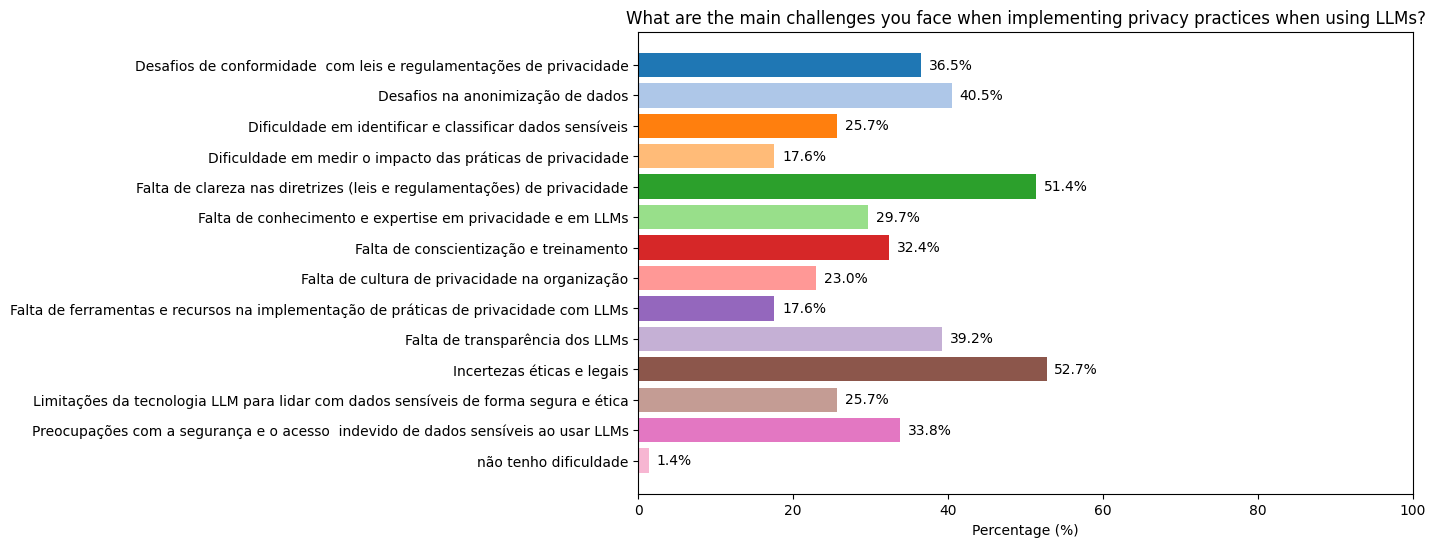

,practices and procedures,Freq,%
0,Desafios de conformidade com leis e regulamentações de privacidade,27,36.5
1,Desafios na anonimização de dados,30,40.5
2,Dificuldade em identificar e classificar dados sensíveis,19,25.7
3,Dificuldade em medir o impacto das práticas de privacidade,13,17.6
4,Falta de clareza nas diretrizes (leis e regulamentações) de privacidade,38,51.4
5,Falta de conhecimento e expertise em privacidade e em LLMs,22,29.7
6,Falta de conscientização e treinamento,24,32.4
7,Falta de cultura de privacidade na organização,17,23.0
8,Falta de ferramentas e recursos na implementação de práticas de privacidade com LLMs,13,17.6
9,Falta de transparência dos LLMs,29,39.2


In [163]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q34)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q34['answer'], result_q34['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q34['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('What are the main challenges you face when implementing privacy practices when using LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q34[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "practices and procedures", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data

## RQ5 - What are the challenges faced by Brazilian software developers in ensuring data privacy when using LLMs in their professional activities?


### Q35 - Which of the following challenges do you find most difficult when ensuring data privacy when using LLMs in your professional activities?
- Identify and classify sensitive data
- Adopt anonymization and pseudonymization measures
- Minimize data collection and retention
- Perform privacy impact assessments
- Achieve transparency on LLM use
- Comply with data privacy laws and regulations
- Ensure accountability for LLM use
- Other

### Q36 - Do you think current legislation is adequate to protect data privacy when using LLMs?
- Strongly Disagree (I believe that the current legislation is inadequate to protect data privacy when using LLMs and needs a complete overhaul)
- Somewhat Disagree (I believe that the current legislation is not sufficient to protect data privacy when using LLMs and needs to be strengthened)
- Neutral (I am not sure whether the current legislation is adequate to protect data privacy when using LLMs)
- Somewhat Agree (I believe that the current legislation provides a good level of protection for data privacy when using LLMs, but some improvements could be made)
- Strongly Agree (I believe that the current legislation provides comprehensive and effective protection for data privacy when using LLMs)

### Q37 - Are you having trouble finding information or resources about data privacy when using LLMs?
- Strongly Disagree (I have no difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Somewhat Disagree (I have a little difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Neutral (I am not sure if I have difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Somewhat Agree (I have some difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Strongly Agree (I have a lot of difficulty finding information and resources on how to ensure data privacy when using LLMs)

### Q38 - How does the lack of specific knowledge about data privacy affect your work with LLMs?
- Difficulty identifying and classifying sensitive data.
- Uncertainty about best practices for data protection
- Difficulty using appropriate security measures
- Risk of not complying with data privacy laws and regulations
- Difficulty assessing privacy impacts
- Uncertainty about liability for use of LLMs
- Risk of data breaches
- Uncertainty about compliance with laws and regulations
- Limited ability to use LLMs safely and responsibly
- Other

## RQ6 - What are the recommendations for ensuring data privacy when using LLMs?

### Q39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?
Open Question

In [168]:
# Creating a DataFrame with a specific column related to data privacy
df_filtered = df['39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?'].to_frame()

# Dropping rows with missing values in the specified column
df_filtered = df_filtered.dropna(subset=['39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?'])

# Resetting the index of the DataFrame after dropping rows
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent
df_filtered = df_filtered.rename(columns={'39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?': 
                        '39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?'})


df_filtered

,39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?
0,"Precisam aprender sobre privacidade e proteção de dados pessoais, governança de IA e as privacy enhance technologies."
1,"Criar regras em Firewall para bloquear ataques a LLM baseados em injeção de SQL, cross-site scripting e outros vetores de ataques, que podem gerar alertas falsos positivos."
2,"sempre use exemplos abstratos dentro de um cenário de hipóteses, nunca dados concretos em um cenário real"
3,Conheça LLMs
4,Anonimização dos dados
5,Utilizar ferramentas que são executadas de forma offline. Não enviar dados pessoais para plataformas externas.
6,"Testes em ambiente segregado. Buscar conhecimento, participar de eventos. Cuidado com os dados manipulados."
7,"Uso restrito, específico e sem compartilhar dados particulares."
8,"Ter uma postura ética, responsável e manter-se atualizado sobre as leis e regulamentações."
9,Sempre anonimizar dados privados ou sensíveis nos prompts.


### Q40 - In your opinion, are more trainings and courses on data privacy and LLMs needed?
- Not necessary.
- Slightly necessary
- Neutral
- Necessary
- Very necessary

In [182]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q40_sts = df["40. Na sua opinião, mais treinamentos e cursos sobre privacidade de dados e LLMs são necessários?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q40_sts = q40_sts.reset_index(drop=False)
q40_sts = q40_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q40_sts["question_anwser"] = q40_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não é necessário.': 1,
                'Pouco necessário': 2,
                'Neutro': 3,
                'Necessário': 4,
                'Muito necessário': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q40_sts['ord_question_anwser'] = q40_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q40_sts = q40_sts.sort_values(by='ord_question_anwser', ascending=True)
q40_sts.drop('ord_question_anwser', axis=1, inplace=True)
q40_sts = q40_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q40_sts.rename(columns={'40. Na sua opinião, mais treinamentos e cursos sobre privacidade de dados e LLMs são necessários?': 'qtde'}, inplace=True)
q40_sts['pct'] = ((q40_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Não é necessário.': 'Not necessary',
                'Pouco necessário': 'Slightly necessary',
                'Neutro': 'Neutral',
                'Necessário': 'Necessary',
                'Muito necessário': 'Very necessary'
                   }
# Atualizando a coluna com os valores traduzidos
q40_sts['question_anwser'] = q40_sts['question_anwser'].map(translation_dict)

#q40_sts

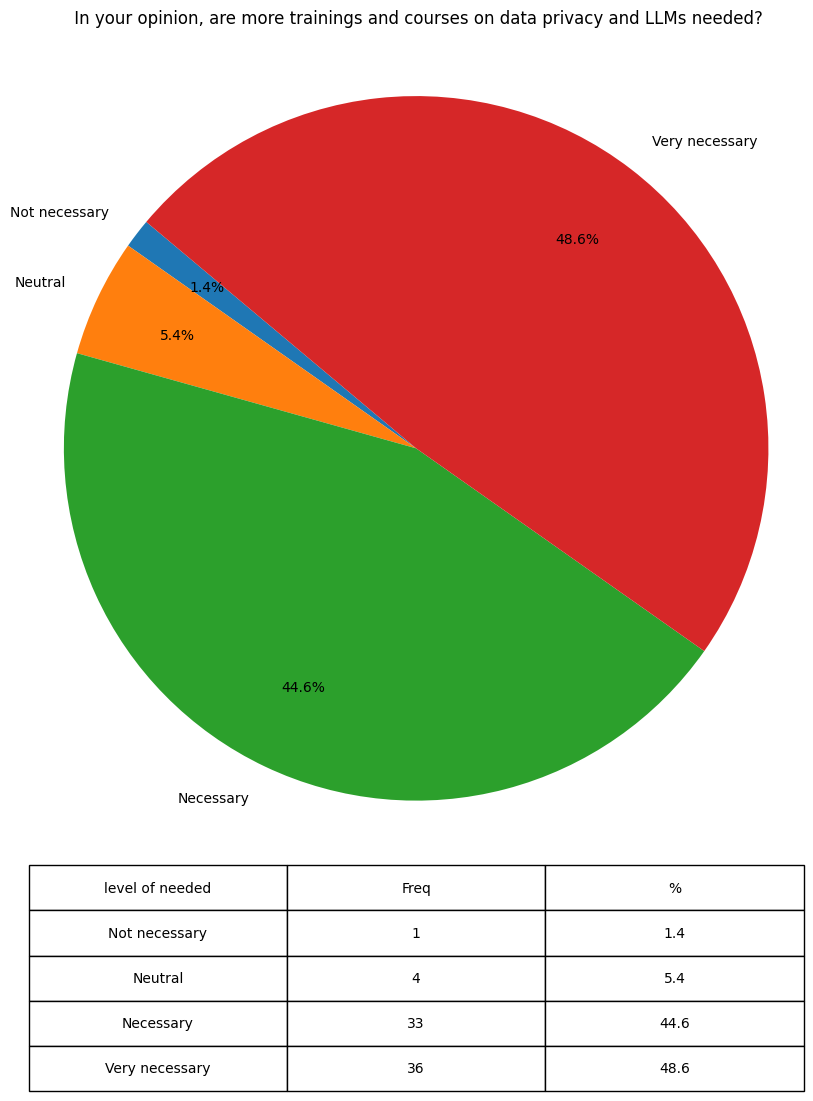

In [181]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q40_sts['qtde']
labels = q40_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title(' In your opinion, are more trainings and courses on data privacy and LLMs needed?')

# Adjusting the position and size of the table
table_data = q40_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of needed", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q41 - In your opinion, how important is it to have an organizational culture that addresses data privacy when using LLMs?
- Not important
- Slightly important
- Neutral
- Important:
- Very important

In [180]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q41_sts = df["41.  Na sua opinião, quão importante é ter uma cultura organizacional que aborda a privacidade de dados ao usar LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q41_sts = q41_sts.reset_index(drop=False)
q41_sts = q41_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q41_sts["question_anwser"] = q41_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não é importante': 1,
                'Pouco importante': 2,
                'Neutro': 3,
                'Importante:.': 4,
                'Muito importante': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q41_sts['ord_question_anwser'] = q41_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q41_sts = q41_sts.sort_values(by='ord_question_anwser', ascending=True)
q41_sts.drop('ord_question_anwser', axis=1, inplace=True)
q41_sts = q41_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q41_sts.rename(columns={'41.  Na sua opinião, quão importante é ter uma cultura organizacional que aborda a privacidade de dados ao usar LLMs? ': 'qtde'}, inplace=True)
q41_sts['pct'] = ((q41_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Não é importante': 'Not important',
                'Pouco importante': 'Slightly important',
                'Neutro': 'Neutral',
                'Importante:.': 'Important',
                'Muito importante': 'Very important'
                   }
# Atualizando a coluna com os valores traduzidos
q41_sts['question_anwser'] = q41_sts['question_anwser'].map(translation_dict)

#q41_sts

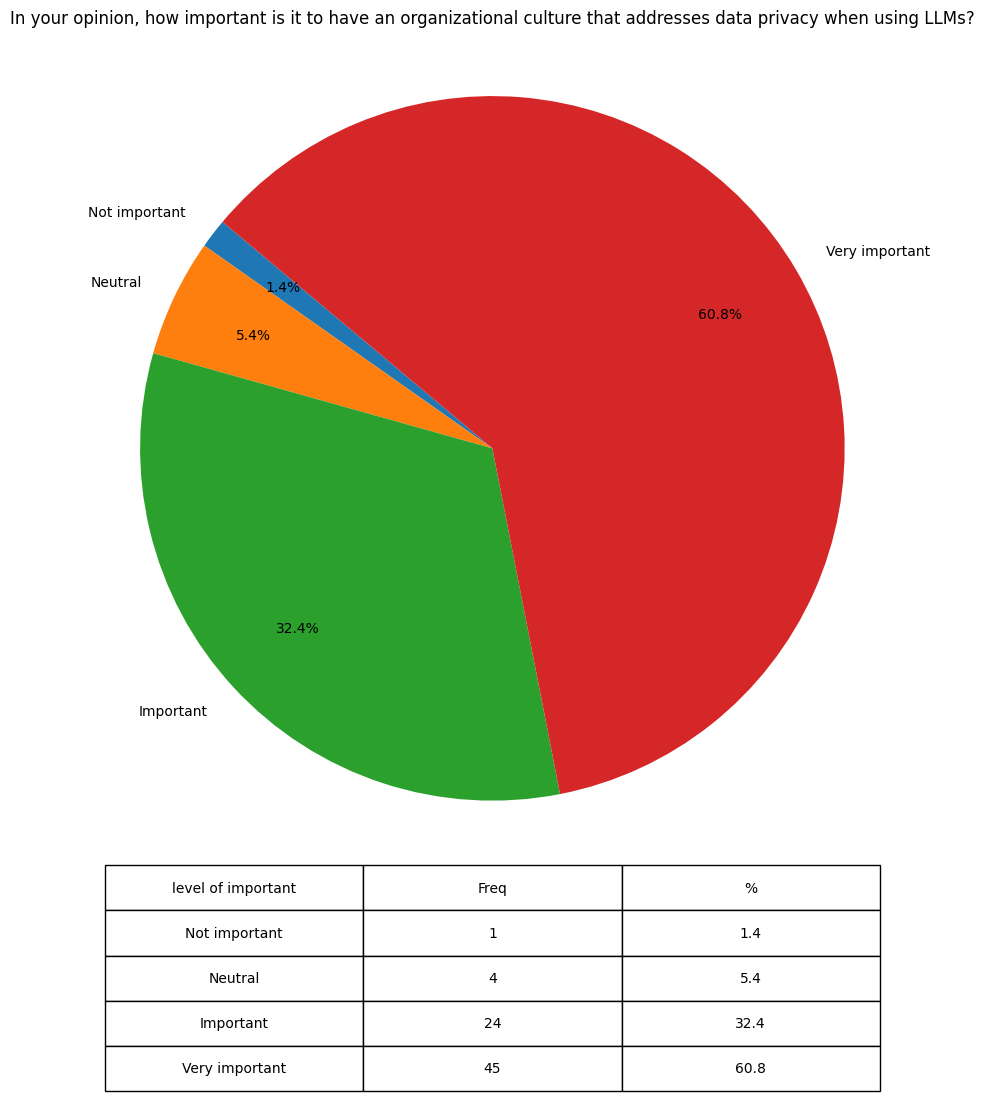

In [179]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q41_sts['qtde']
labels = q41_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('In your opinion, how important is it to have an organizational culture that addresses data privacy when using LLMs?')

# Adjusting the position and size of the table
table_data = q41_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "level of important", "qtde": "Freq", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q42 - What kind of support or additional resources do you think would be helpful to improve data privacy protection when using LLMs?
- Clear guidelines and best practices
- Privacy tools and technologies
- Privacy training and capacity building
- Public awareness and education campaigns
- Legal and regulatory guidance
- Privacy assessment solutions
- Privacy research and development for LLMs
- Collaboration and knowledge sharing forums
- Other

In [187]:
column_name = "42. Que tipo de suporte ou recursos adicionais você acredita que seriam úteis para melhorar a proteção da privacidade de dados ao usar LLMs? (Marque todas as opções que se aplicam)"
result_q42 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Diretrizes e melhores práticas claras':'Clear guidelines and best practices',
    'Ferramentas e tecnologias de privacidade':'Privacy tools and technologies',
    'Treinamentos e capacitação em privacidade':'Privacy training and capacity building',
    'Campanhas de educação e conscientização pública':'Public awareness and education campaigns',
    'Orientação jurídica e regulatória':'Legal and regulatory guidance',
    'Soluções de avaliação de privacidade':'Privacy assessment solutions',
    'Pesquisa e desenvolvimento em privacidade para LLMs':'Privacy research and development for LLMs',
    'Fóruns de colaboração e compartilhamento de conhecimento':'Collaboration and knowledge sharing forums',
    'a possibilidade de IAs de navegação anônima amnésica':'Other',
    'nenhum':'Other'
}

result_q42['answer'] = result_q42['answer'].str.strip()

# Atualizando a coluna com os valores traduzidos
result_q42['answer'] = result_q42['answer'].map(translation_dict)

result_q42.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q42 = result_q42.groupby('answer', as_index=False).sum()


result_q42['pct'] = ((result_q42['qtde']/df.shape[0])*100).round(1)

result_q42 = result_q42.sort_values(by='answer', ascending=True)
result_q42 = result_q42.reset_index(drop=True)


result_q42

,answer,qtde,pct
0,Clear guidelines and best practices,50,67.6
1,Collaboration and knowledge sharing forums,32,43.2
2,Legal and regulatory guidance,44,59.5
3,Other,2,2.7
4,Privacy assessment solutions,34,45.9
5,Privacy research and development for LLMs,38,51.4
6,Privacy tools and technologies,46,62.2
7,Privacy training and capacity building,60,81.1
8,Public awareness and education campaigns,46,62.2


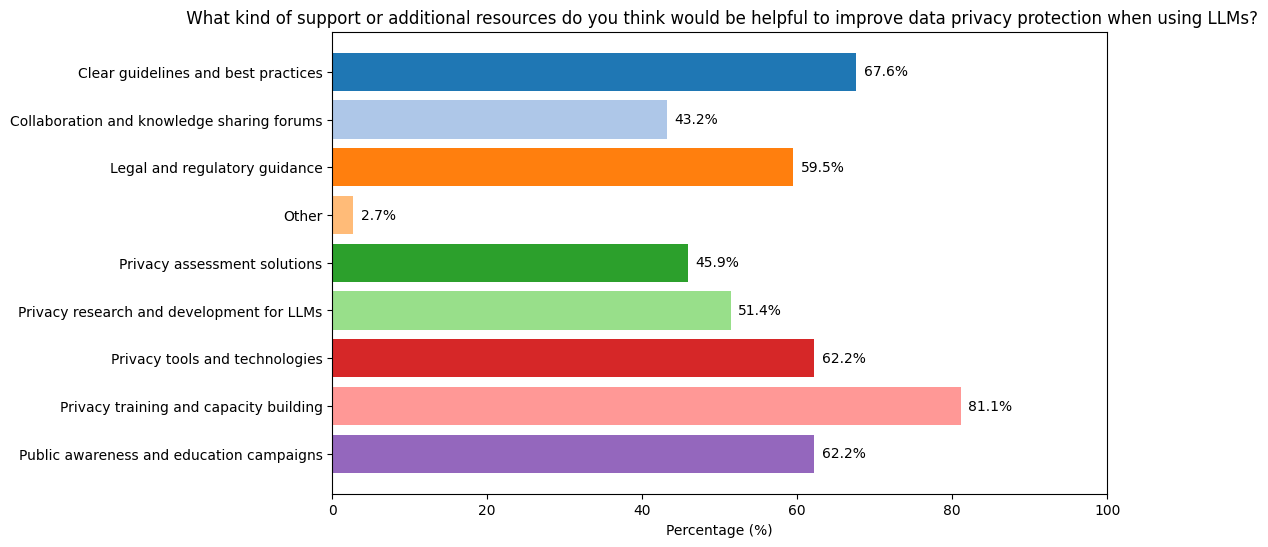

,support or additional resources,Freq,%
0,Desafios de conformidade com leis e regulamentações de privacidade,27,36.5
1,Desafios na anonimização de dados,30,40.5
2,Dificuldade em identificar e classificar dados sensíveis,19,25.7
3,Dificuldade em medir o impacto das práticas de privacidade,13,17.6
4,Falta de clareza nas diretrizes (leis e regulamentações) de privacidade,38,51.4
5,Falta de conhecimento e expertise em privacidade e em LLMs,22,29.7
6,Falta de conscientização e treinamento,24,32.4
7,Falta de cultura de privacidade na organização,17,23.0
8,Falta de ferramentas e recursos na implementação de práticas de privacidade com LLMs,13,17.6
9,Falta de transparência dos LLMs,29,39.2


In [188]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q34)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q42['answer'], result_q42['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q42['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title(' What kind of support or additional resources do you think would be helpful to improve data privacy protection when using LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q34[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "support or additional resources", "qtde": "Freq", "pct": "%"}, inplace=True)
table_data